In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score

In [2]:
# Load the dataset
df = pd.read_csv('nyc_tripdata.csv', nrows=100000)

In [3]:

df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

In [4]:
df.shape

(100000, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               100000 non-null  int64  
 1   tpep_pickup_datetime   100000 non-null  object 
 2   tpep_dropoff_datetime  100000 non-null  object 
 3   passenger_count        100000 non-null  int64  
 4   trip_distance          100000 non-null  float64
 5   pickup_longitude       100000 non-null  float64
 6   pickup_latitude        100000 non-null  float64
 7   RateCodeID             100000 non-null  int64  
 8   store_and_fwd_flag     100000 non-null  object 
 9   dropoff_longitude      100000 non-null  float64
 10  dropoff_latitude       100000 non-null  float64
 11  payment_type           100000 non-null  int64  
 12  fare_amount            100000 non-null  float64
 13  extra                  100000 non-null  float64
 14  mta_tax                100000 non-nul

# DATA CLEANING

In [6]:
#1: Remove irrelevant columns
# Strip whitespace from column names
df.columns = [col.strip() for col in df.columns]

# Drop the 'store_and_fwd_flag' column if it exists
df.drop(columns=['store_and_fwd_flag'], inplace=True, errors='ignore')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               100000 non-null  int64  
 1   tpep_pickup_datetime   100000 non-null  object 
 2   tpep_dropoff_datetime  100000 non-null  object 
 3   passenger_count        100000 non-null  int64  
 4   trip_distance          100000 non-null  float64
 5   pickup_longitude       100000 non-null  float64
 6   pickup_latitude        100000 non-null  float64
 7   RateCodeID             100000 non-null  int64  
 8   dropoff_longitude      100000 non-null  float64
 9   dropoff_latitude       100000 non-null  float64
 10  payment_type           100000 non-null  int64  
 11  fare_amount            100000 non-null  float64
 12  extra                  100000 non-null  float64
 13  mta_tax                100000 non-null  float64
 14  tip_amount             100000 non-nul

In [8]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'dropoff_longitude',
       'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount'],
      dtype='object')

In [9]:
# 2. Remove duplicates
df = df.drop_duplicates()

In [10]:
# 3. Handle missing values
df = df.dropna()

In [11]:
# 4. Convert datetime column
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

In [12]:
# 5. Remove trips with zero or negative distances
df = df[df['trip_distance'] > 0]

In [13]:
# 6. Remove negative or zero fares
df = df[df['fare_amount'] > 0]

In [14]:
# 7. Filter unrealistic trip durations

# Ensure datetime columns are in the correct format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], errors='coerce')

# Calculate trip duration in seconds
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()/60

# Filter unrealistic trip durations (30 seconds to 2 hours)
df = df[(df['trip_duration'] > 30) & (df['trip_duration'] < 7200)]

In [15]:
# 8. Remove outliers using IQR
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['fare_amount'] >= lower_bound) & (df['fare_amount'] <= upper_bound)]

In [16]:
# 9. Filter incorrect geolocation data
NYC_BOUNDS = {'lat_min': 40.5, 'lat_max': 41.2, 'lon_min': -74.3, 'lon_max': -73.7}
df = df[(df['pickup_latitude'].between(NYC_BOUNDS['lat_min'], NYC_BOUNDS['lat_max'])) &
        (df['pickup_longitude'].between(NYC_BOUNDS['lon_min'], NYC_BOUNDS['lon_max'])) &
        (df['dropoff_latitude'].between(NYC_BOUNDS['lat_min'], NYC_BOUNDS['lat_max'])) &
        (df['dropoff_longitude'].between(NYC_BOUNDS['lon_min'], NYC_BOUNDS['lon_max']))]

In [17]:
# 10. Ensure data types are correct
df['passenger_count'] = df['passenger_count'].astype(int)

In [18]:
# 11. Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [19]:
df

vendorid tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
8             1  2015-01-10 20:33:39   2015-01-10 21:11:35                3   
27            2  2015-01-15 19:05:42   2015-01-15 19:49:07                1   
37            1  2015-01-10 19:12:21   2015-01-10 19:46:08                1   
58            2  2015-01-25 00:13:09   2015-01-25 01:02:40                1   
78            2  2015-01-15 14:00:41   2015-01-15 14:31:42                5   
...         ...                  ...                   ...              ...   
99918         2  2015-01-19 14:53:19   2015-01-19 15:32:49                1   
99948         1  2015-01-19 23:46:52   2015-01-20 00:31:14                1   
99963         1  2015-01-19 23:47:03   2015-01-20 00:29:44                1   
99996         2  2015-01-21 18:16:49   2015-01-21 19:11:10                1   
99998         2  2015-01-21 18:16:50   2015-01-21 19:28:34                5   

       trip_distance  pickup_longitude  pickup_latitude  ratecodeid  \
8              18.20        -73.783043        40.644356           2   
27             18.06        -73.786575        40.644127           2   
37             16.40        -73.977097        40.763172           2   
58             10.20        -73.997612        40.762241           1   
78              7.48        -73.870819        40.773701           1   
...              ...               ...              ...         ...   
99918          16.58        -73.981796        40.760490           2   
99948          11.90        -73.782036        40.644592           1   
99963          17.30        -74.003792        40.741833           1   
99996          18.49        -74.003777        40.731682           2   
99998          18.76        -73.866737        40.770859           1   

       dropoff_longitude  dropoff_latitude  payment_type  fare_amount  extra  \
8             -73.987595         40.759357             2         52.0    0.0   
27            -73.985603         40.743530             1         52.0    0.0   
37            -73.790710         40.644276             1         52.0    0.0   
58            -73.908577         40.690048             2         39.0    0.5   
78            -73.968697         40.762680             2         27.0    0.0   
...                  ...               ...           ...          ...    ...   
99918         -73.789902         40.646927             2         52.0    0.0   
99948         -73.960632         40.663200             3          2.5    0.5   
99963         -73.999580         40.598049             2         51.0    0.5   
99996         -73.783485         40.643738             1         52.0    0.0   
99998         -73.977158         40.596611             2         58.5    1.0   

       mta_tax  tip_amount  tolls_amount  improvement_surcharge  total_amount  \
8          0.5         0.0          5.33                    0.3         58.13   
27         0.5         6.0          5.33                    0.3         64.13   
37         0.5        10.0          0.00                    0.3         62.80   
58         0.5         0.0          0.00                    0.3         40.30   
78         0.5         0.0          0.00                    0.3         27.80   
...        ...         ...           ...                    ...           ...   
99918      0.5         0.0          5.33                    0.3         58.13   
99948      0.5         0.0          0.00                    0.3          3.80   
99963      0.5         0.0          0.00                    0.3         52.30   
99996      0.5         5.0          0.00                    0.3         57.80   
99998      0.5         0.0          0.00                    0.3         60.30   

       trip_duration  
8          37.933333  
27         43.416667  
37         33.783333  
58         49.516667  
78         31.016667  
...              ...  
99918      39.500000  
99948      44.366667  
99963      42.683333  
99996      54.350000  
99998      71.7333

# EXPLORATORY DATA ANALYSIS(EDA)


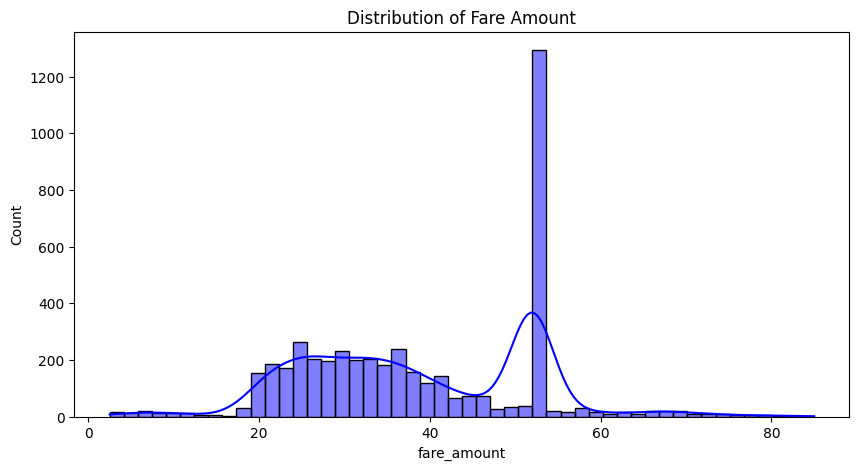

In [20]:
#1.
plt.figure(figsize=(10,5))
sns.histplot(df['fare_amount'], bins=50, kde=True, color='blue')
plt.title('Distribution of Fare Amount')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\1732286515.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = df.groupby('distance_bin').agg({'fare_amount': 'mean'}).reset_index()


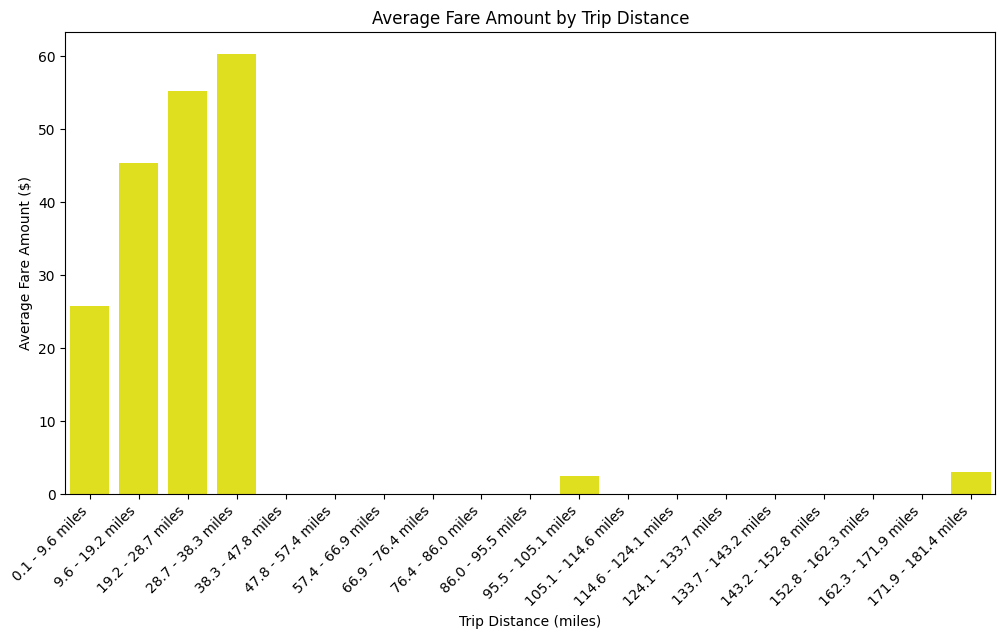

In [21]:
#2.
distance_bins = np.linspace(df['trip_distance'].min(), df['trip_distance'].max(), 20)
df['distance_bin'] = pd.cut(df['trip_distance'], bins=distance_bins)
agg_df = df.groupby('distance_bin').agg({'fare_amount': 'mean'}).reset_index()
agg_df['distance_bin'] = agg_df['distance_bin'].apply(lambda x: f"{x.left:.1f} - {x.right:.1f} miles")
plt.figure(figsize=(12, 6))
sns.barplot(x=agg_df['distance_bin'], y=agg_df['fare_amount'], color='yellow')
plt.title('Average Fare Amount by Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Average Fare Amount ($)')
plt.xticks(rotation=45, ha='right')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\2887165349.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['hour'], palette='viridis')


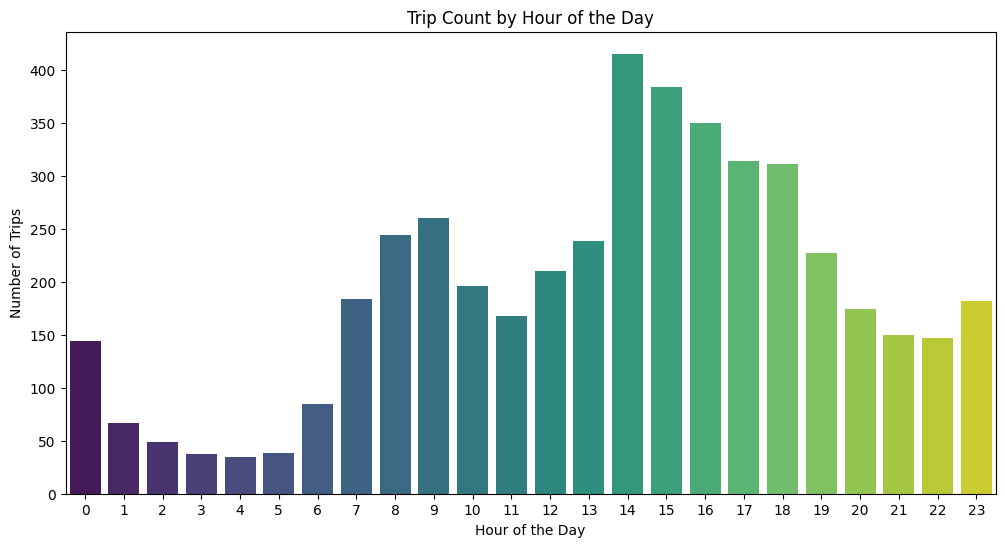

In [22]:
#3.
plt.figure(figsize=(12,6))
df['hour'] = df['tpep_pickup_datetime'].dt.hour
sns.countplot(x=df['hour'], palette='viridis')
plt.title('Trip Count by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\1221725808.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['passenger_count'], y=df['fare_amount'], palette='magma')


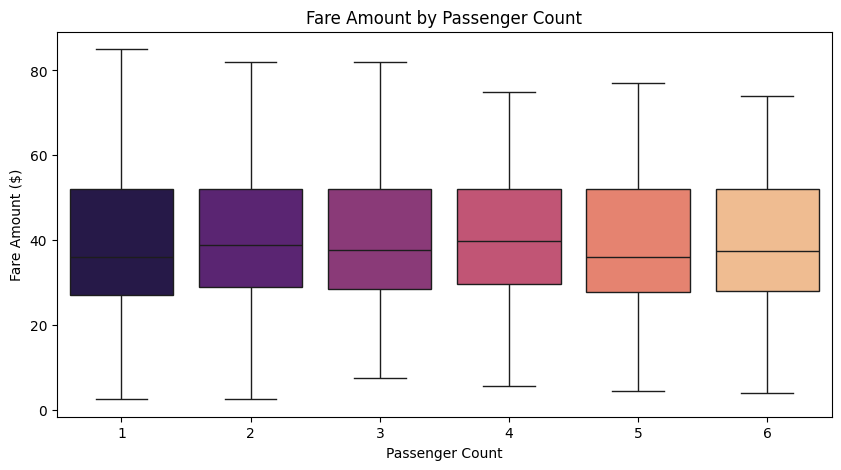

In [23]:
#4.
plt.figure(figsize=(10,5))
sns.boxplot(x=df['passenger_count'], y=df['fare_amount'], palette='magma')
plt.title('Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount ($)')
plt.show()

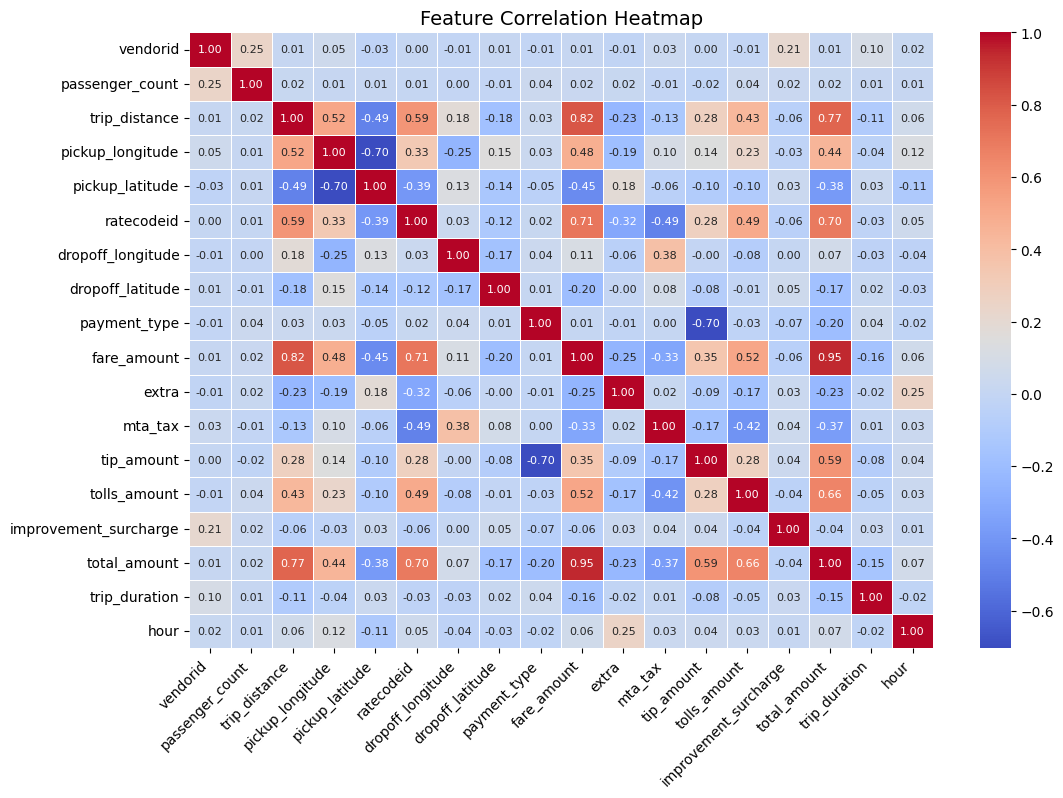

In [24]:
#5.
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.show()

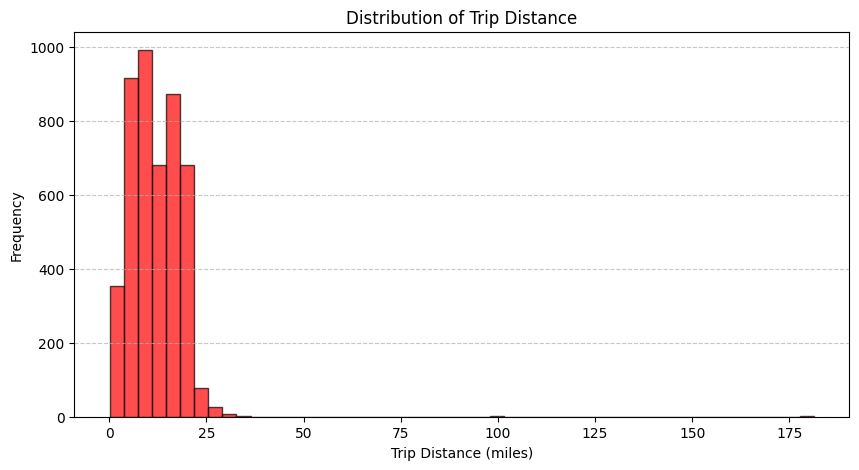

In [25]:
#6.
plt.figure(figsize=(10, 5))
plt.hist(df['trip_distance'], bins=50, color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\734216297.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=df['hour'], y=df['fare_amount'], estimator=np.mean, ci=None, marker='o', color='black')


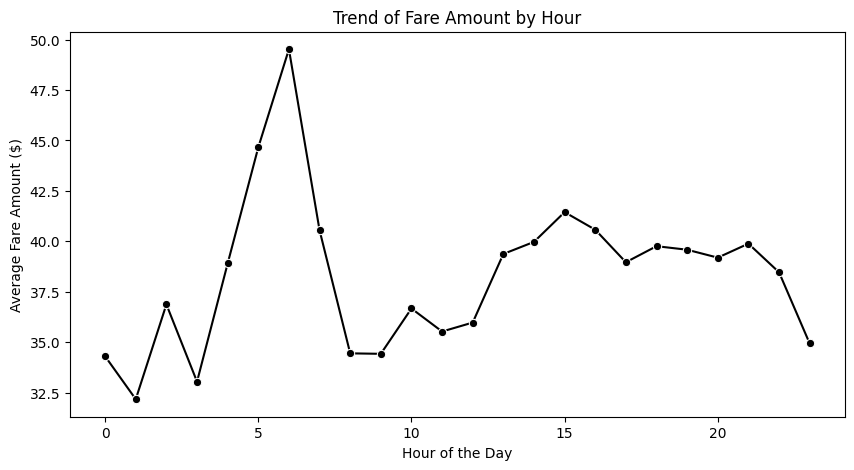

In [26]:
#7.
plt.figure(figsize=(10, 5))
sns.lineplot(x=df['hour'], y=df['fare_amount'], estimator=np.mean, ci=None, marker='o', color='black')
plt.title('Trend of Fare Amount by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Fare Amount ($)')
plt.show()

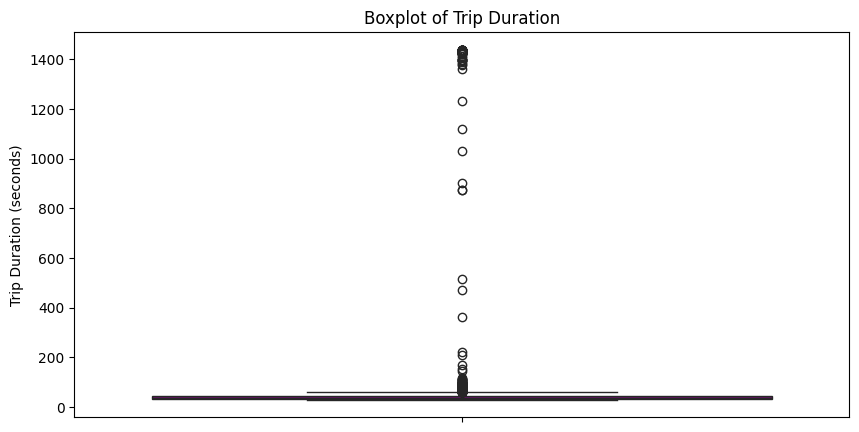

In [27]:
#8.
plt.figure(figsize=(10,5))
sns.boxplot(y=df['trip_duration'], color='purple')
plt.title('Boxplot of Trip Duration')
plt.ylabel('Trip Duration (seconds)')
plt.show()

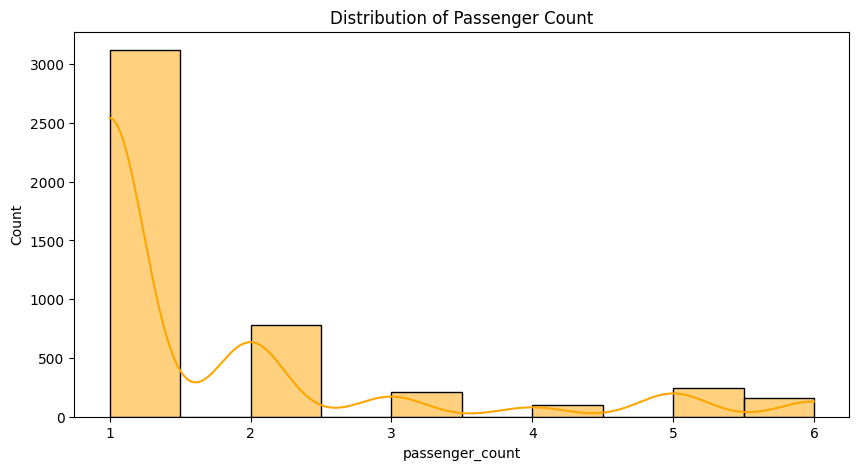

In [28]:
#9.
plt.figure(figsize=(10,5))
sns.histplot(df['passenger_count'], bins=10, kde=True, color='orange')
plt.title('Distribution of Passenger Count')
plt.show()

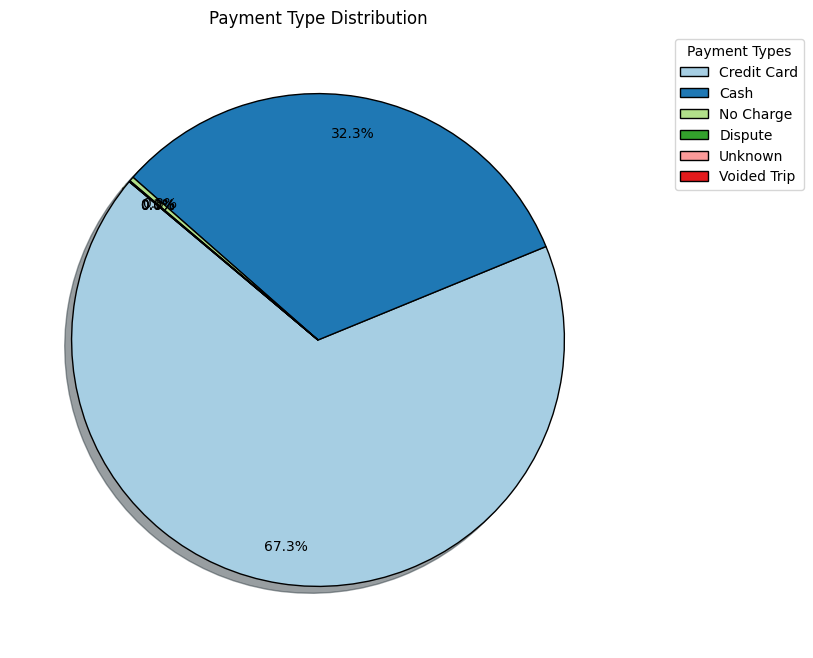

In [29]:
#10.
payment_labels = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided Trip'
}
payment_counts = df['payment_type'].value_counts().reindex(payment_labels.keys(), fill_value=0)
labels = [payment_labels.get(i, i) for i in payment_counts.index]
plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    payment_counts,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=plt.cm.Paired.colors,
    pctdistance=0.85,
    shadow=True
)
plt.legend(wedges, labels, title="Payment Types", loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title('Payment Type Distribution')
plt.ylabel('')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\1112622907.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_duration = df.groupby('distance_bin')['trip_duration'].mean()


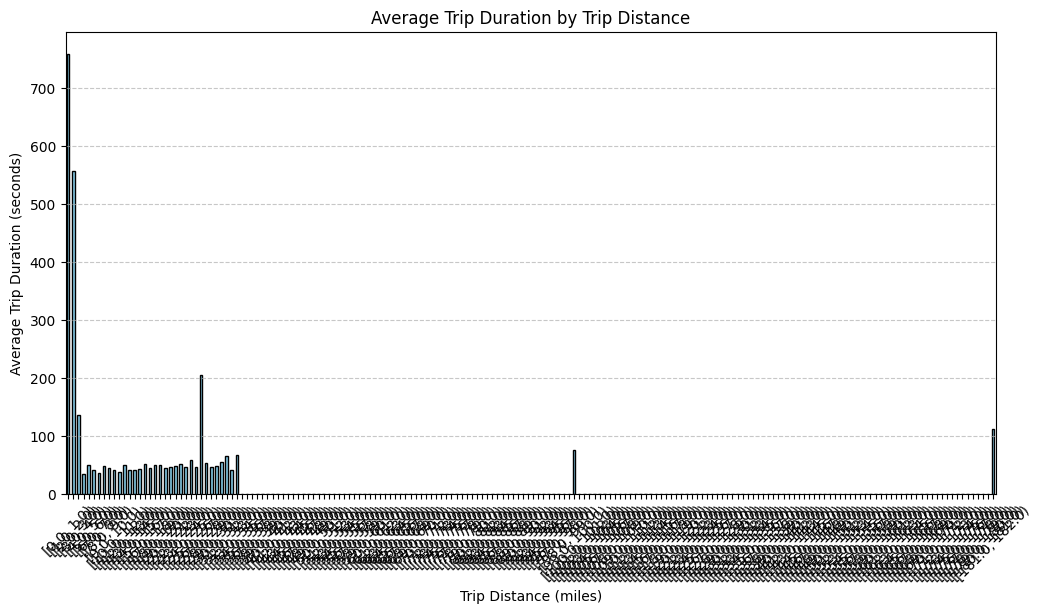

In [30]:
#11.
bins = np.arange(0, df['trip_distance'].max() + 1, 1)  # Bin every 1 mile
df['distance_bin'] = pd.cut(df['trip_distance'], bins, right=False)
avg_duration = df.groupby('distance_bin')['trip_duration'].mean()
plt.figure(figsize=(12,6))
avg_duration.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Trip Duration by Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Average Trip Duration (seconds)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


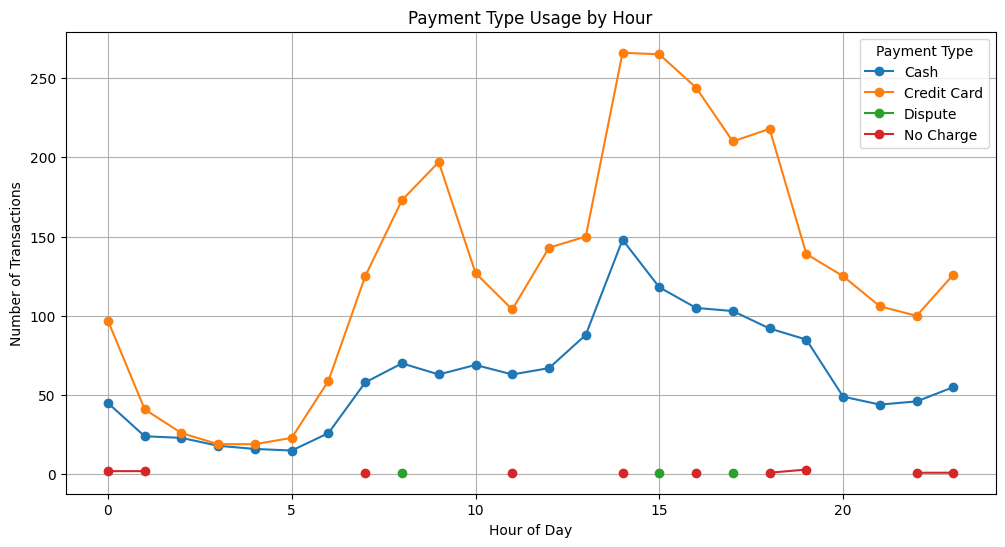

In [31]:
#12.
payment_type_map = {1: 'Credit Card',2: 'Cash',3: 'No Charge',4: 'Dispute'}
df['payment_type'] = df['payment_type'].map(payment_type_map)
payment_type_counts = df.groupby(['hour', 'payment_type']).size().unstack()
ax = payment_type_counts.plot(kind='line', marker='o', figsize=(12,6))
payment_type_labels = payment_type_counts.columns.tolist()
ax.legend(title='Payment Type', labels=payment_type_labels)

plt.title('Payment Type Usage by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\3654369081.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['payment_type'], y=df['fare_amount'], palette='coolwarm')


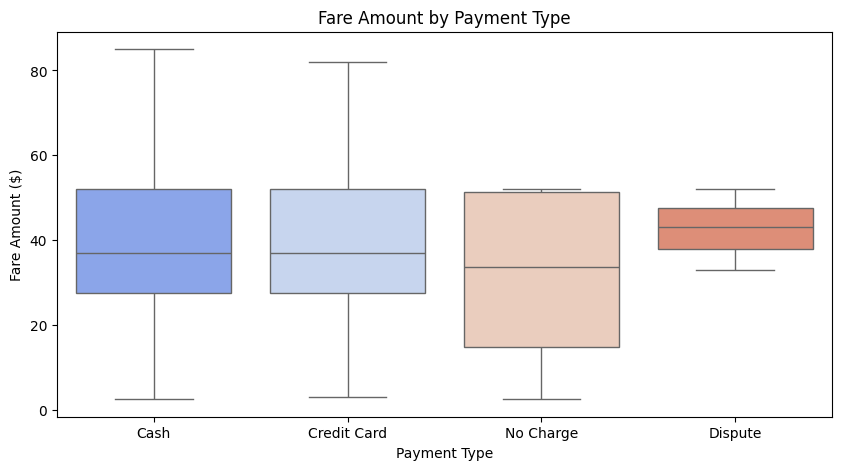

In [32]:
#13
plt.figure(figsize=(10,5))
sns.boxplot(x=df['payment_type'], y=df['fare_amount'], palette='coolwarm')
plt.title('Fare Amount by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Fare Amount ($)')
plt.show()

In [33]:
# Remove invalid pickup/drop-off times
df = df[df['tpep_pickup_datetime'] < df['tpep_dropoff_datetime']]

In [34]:
# Extract date and hour from already formatted datetime columns
datetime_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
for col in datetime_cols:
    if col in df.columns:
        df[f"{col}_date"] = df[col].dt.day  # Extract date
        df[f"{col}_hour"] = df[col].dt.hour  # Extract hour
        df.drop(columns=[col], inplace=True)  # Drop original datetime column

In [35]:
# Remove rows where the sum of components does not match fare amount
df['calculated_total'] = df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tolls_amount'] + df['improvement_surcharge'] + df['tip_amount']
df = df[df['calculated_total'] == df['total_amount']]
df.drop(columns=['calculated_total'], inplace=True)

In [36]:
# Create fare-related features
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance']
df['fare_per_minute'] = df['fare_amount'] / df['trip_duration']

In [37]:
# Remove rows with cash payments
#df = df[df['payment_type'] != 2]
df["payment_type"] = df["payment_type"].map({
    "Credit Card": 1,
    "Cash": 2,
    "No Charge": 3,
    "Dispute": 4,
    "Unknown": 5
})

In [38]:
df.drop(columns=['distance_bin'], inplace=True, errors='ignore')

In [39]:
df

vendorid  passenger_count  trip_distance  pickup_longitude  \
27            2                1          18.06        -73.786575   
37            1                1          16.40        -73.977097   
58            2                1          10.20        -73.997612   
78            2                5           7.48        -73.870819   
83            2                1          15.20        -73.801262   
...         ...              ...            ...               ...   
99845         1                3           4.70        -74.001831   
99948         1                1          11.90        -73.782036   
99963         1                1          17.30        -74.003792   
99996         2                1          18.49        -74.003777   
99998         2                5          18.76        -73.866737   

       pickup_latitude  ratecodeid  dropoff_longitude  dropoff_latitude  \
27           40.644127           2         -73.985603         40.743530   
37           40.763172           2         -73.790710         40.644276   
58           40.762241           1         -73.908577         40.690048   
78           40.773701           1         -73.968697         40.762680   
83           40.667728           2         -73.993355         40.756001   
...                ...         ...                ...               ...   
99845        40.724556           1         -73.984268         40.698364   
99948        40.644592           1         -73.960632         40.663200   
99963        40.741833           1         -73.999580         40.598049   
99996        40.731682           2         -73.783485         40.643738   
99998        40.770859           1         -73.977158         40.596611   

       payment_type  fare_amount  ...  improvement_surcharge  total_amount  \
27                1         52.0  ...                    0.3         64.13   
37                1         52.0  ...                    0.3         62.80   
58                2         39.0  ...                    0.3         40.30   
78                2         27.0  ...                    0.3         27.80   
83                1         52.0  ...                    0.3         72.46   
...             ...          ...  ...                    ...           ...   
99845             2         22.5  ...                    0.3         24.30   
99948             3          2.5  ...                    0.3          3.80   
99963             2         51.0  ...                    0.3         52.30   
99996             1         52.0  ...                    0.3         57.80   
99998             2         58.5  ...                    0.3         60.30   

       trip_duration  hour  tpep_pickup_datetime_date  \
27         43.416667    19                         15   
37         33.783333    19                         10   
58         49.516667     0                         25   
78         31.016667    14                         15   
83         57.950000    14                         15   
...              ...   ...                        ...   
99845      31.533333    19                         23   
99948      44.366667    23                         19   
99963      42.683333    23                         19   
99996      54.350000    18                         21   
99998      71.733333    18                         21   

       tpep_pickup_datetime_hour  tpep_dropoff_datetime_date  \
27                            19                          15   
37                            19                          10   
58                             0                          25   
78                            14                          15   
83                            14                          15   
...                          ...                         ...   
99845                         19                          23   
99948                         23                          20   
99963                         23                          20   
99996          

In [40]:
# Define features and target column
X = df.drop(columns=['tip_amount'])  # Replace 'target_column' with the actual target
y = df['tip_amount']

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2947 entries, 27 to 99998
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   vendorid                    2947 non-null   int64  
 1   passenger_count             2947 non-null   int32  
 2   trip_distance               2947 non-null   float64
 3   pickup_longitude            2947 non-null   float64
 4   pickup_latitude             2947 non-null   float64
 5   ratecodeid                  2947 non-null   int64  
 6   dropoff_longitude           2947 non-null   float64
 7   dropoff_latitude            2947 non-null   float64
 8   payment_type                2947 non-null   int64  
 9   fare_amount                 2947 non-null   float64
 10  extra                       2947 non-null   float64
 11  mta_tax                     2947 non-null   float64
 12  tip_amount                  2947 non-null   float64
 13  tolls_amount                2947 non

In [42]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
def plot_train_vs_test(y_train, train_pred, y_test, test_pred, model_name):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, train_pred, alpha=0.5, color="blue", label="Train Predictions")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], "--r", label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} - Training Set")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, test_pred, alpha=0.5, color="green", label="Test Predictions")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--r", label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name} - Test Set")
    plt.legend()
    plt.show()

In [45]:
def plot_residuals(y_test, test_pred, model_name):
    """Plot residuals."""
    residuals = y_test - test_pred
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=30, kde=True, color="purple")
    plt.axvline(x=0, color="red", linestyle="--")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.title(f"Residual Distribution - {model_name}")
    plt.show()

In [46]:
def plot_feature_importance(model, X, model_name):
    """Plot feature importance for models that support it."""
    if hasattr(model, "feature_importances_"):
        plt.figure(figsize=(10, 5))
        importance = model.feature_importances_
        sorted_idx = np.argsort(importance)[::-1]
        plt.bar(range(len(importance)), importance[sorted_idx], align='center')
        plt.xticks(range(len(importance)), X.columns[sorted_idx], rotation=90)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title(f"Feature Importance - {model_name}")
        plt.show()

In [47]:
def plot_loss(y_test, test_pred, model_name):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label="Actual", marker="o", linestyle="-")
    plt.plot(test_pred, label="Predicted", marker="x", linestyle="--")
    plt.xlabel("Data Points")
    plt.ylabel("Values")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.legend()
    plt.show()


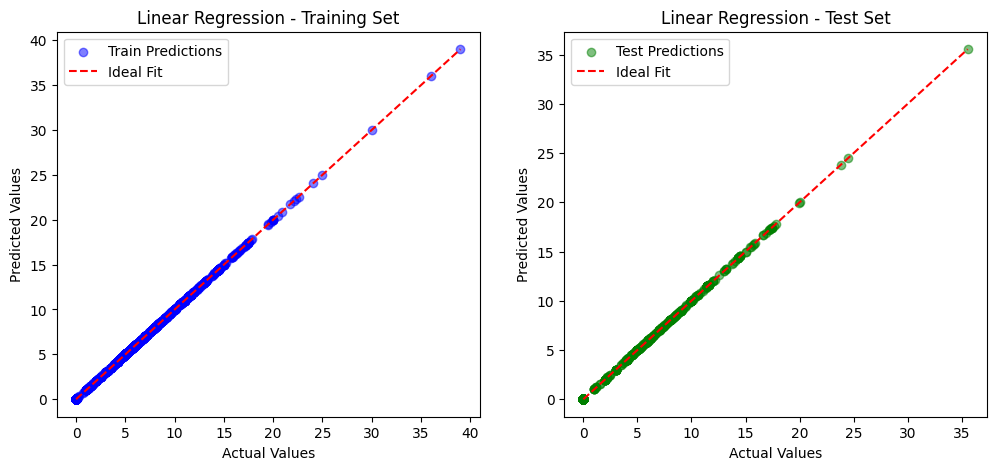

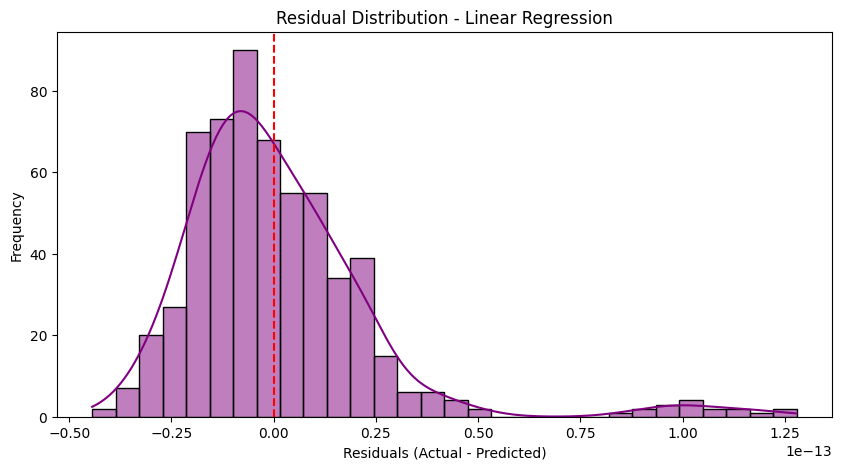

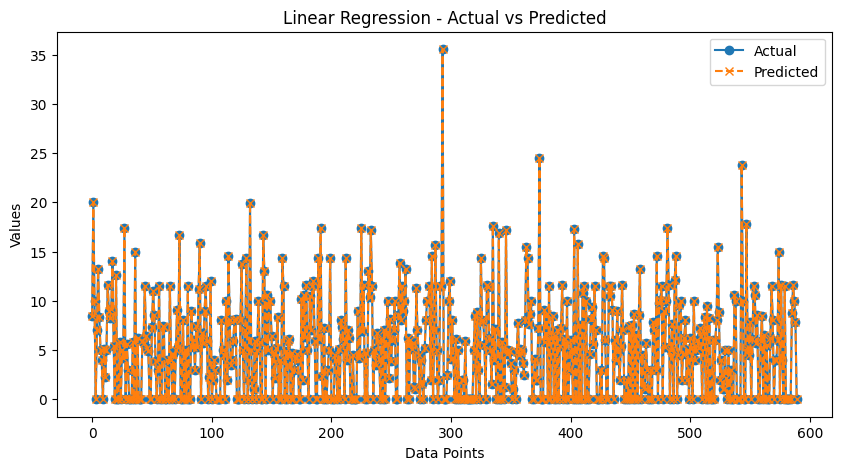

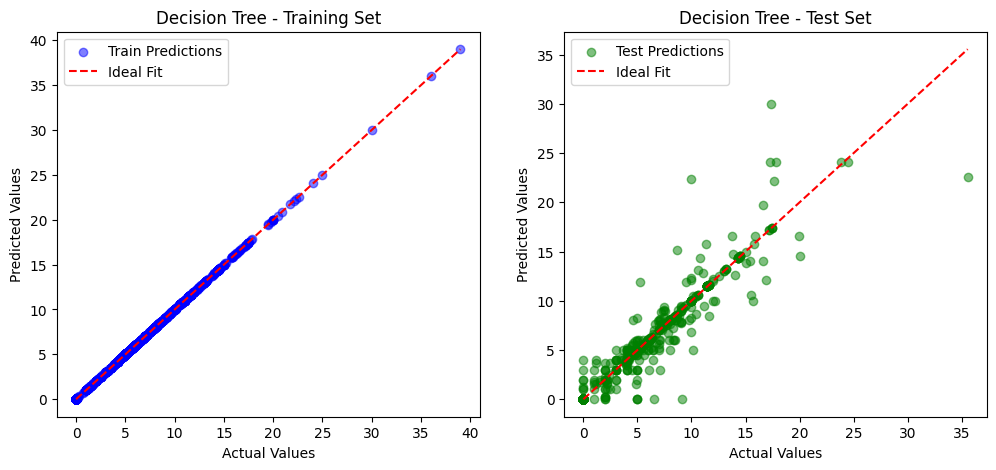

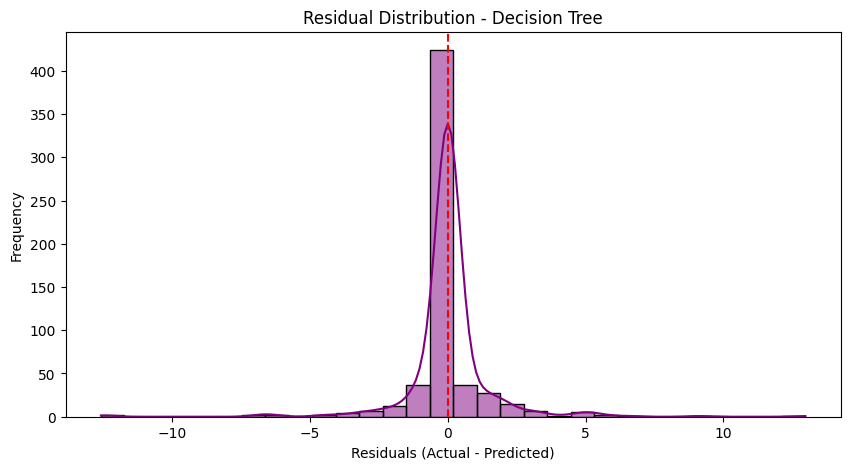

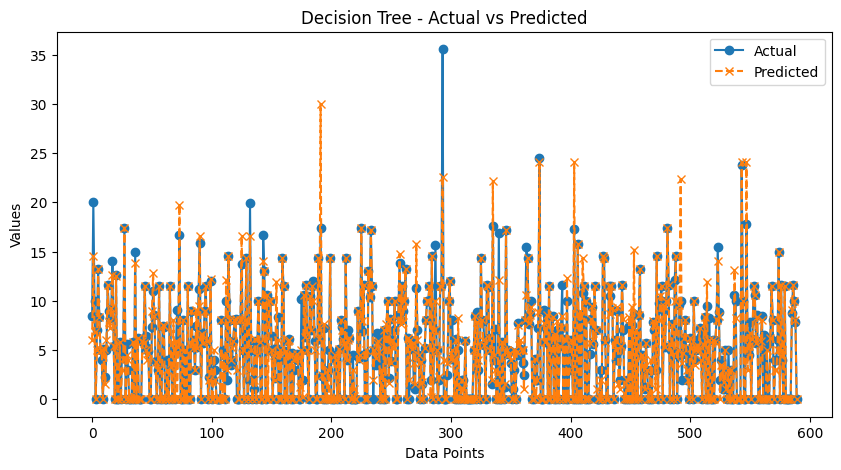

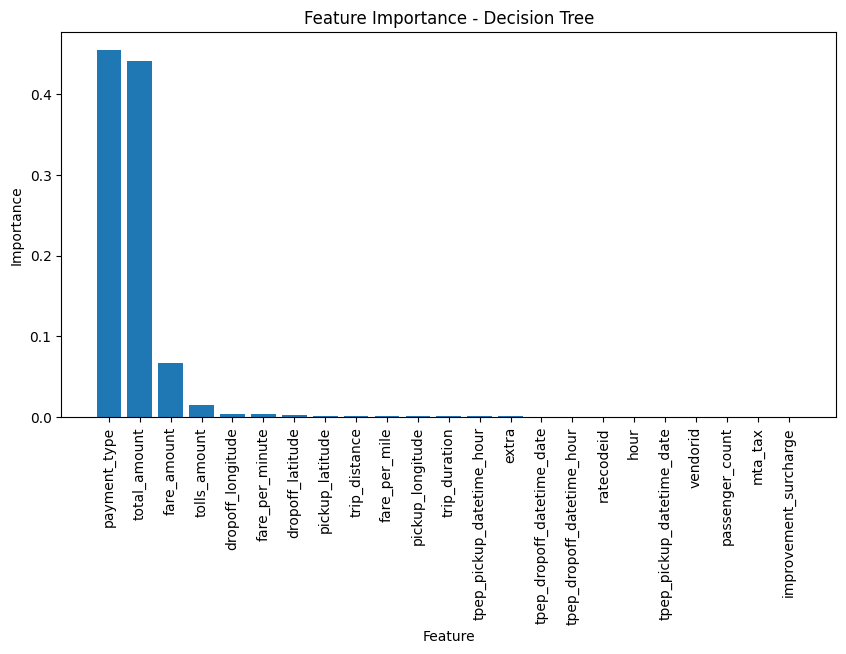

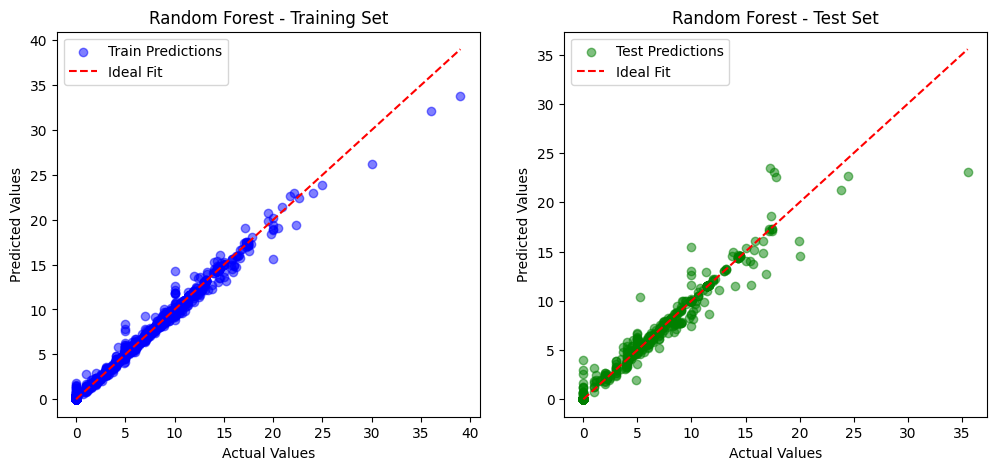

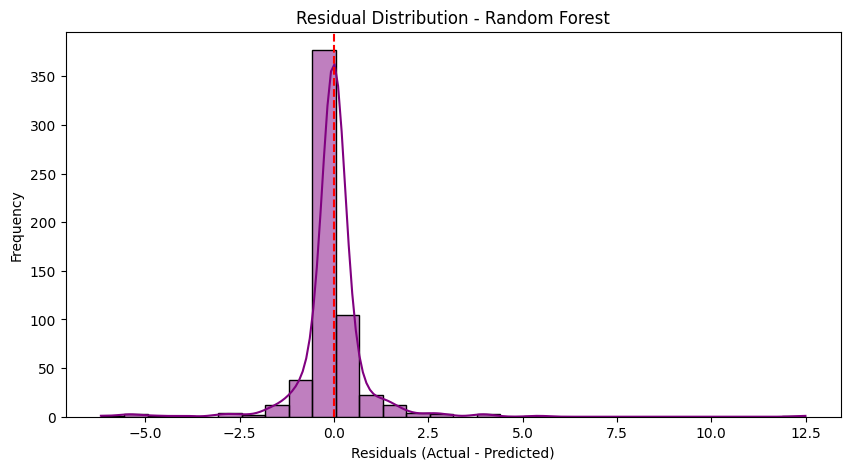

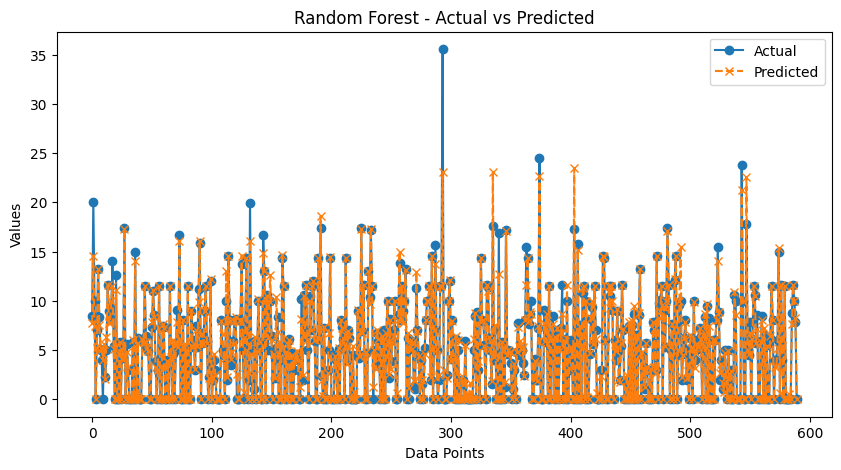

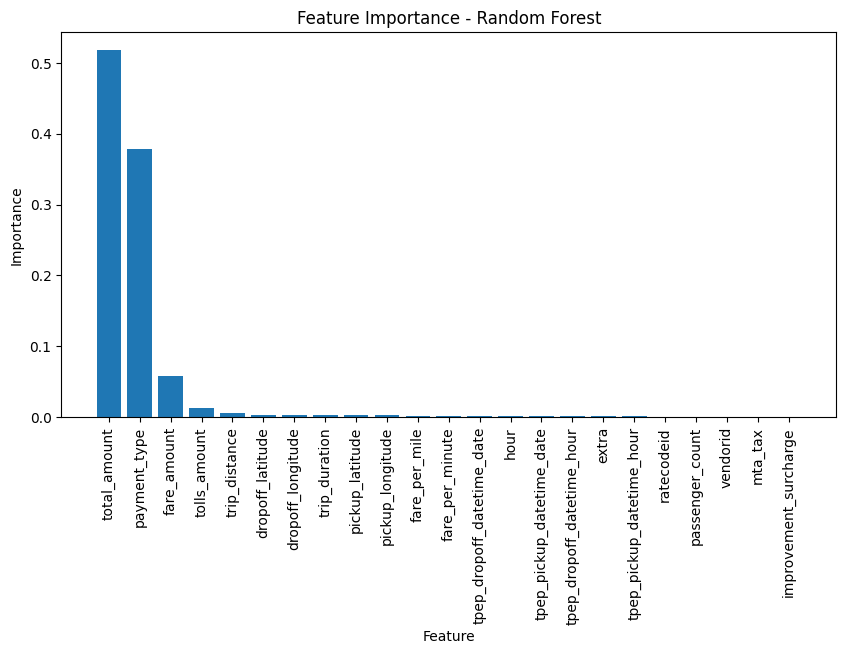

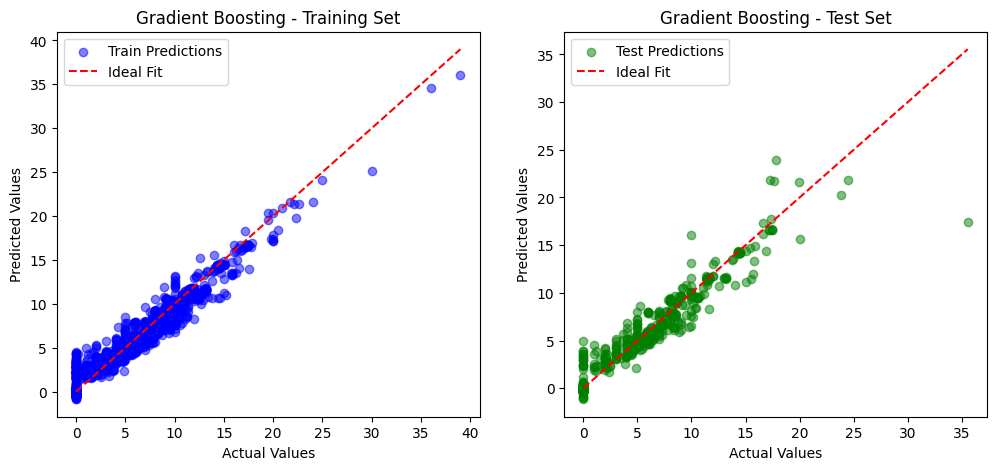

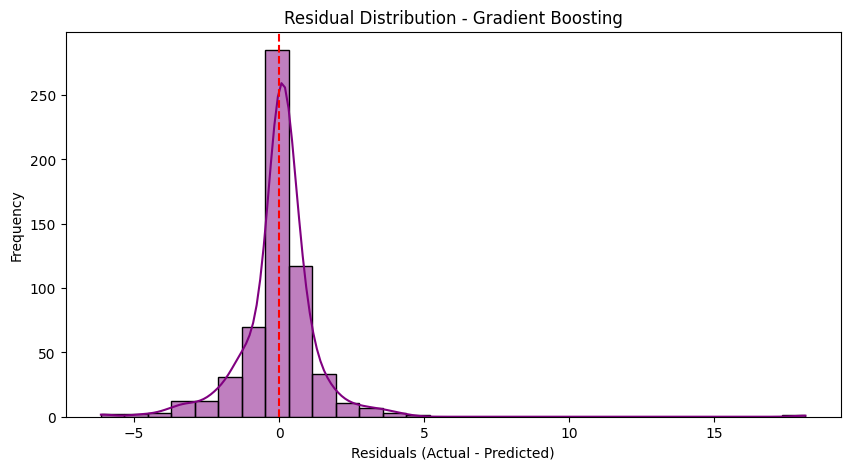

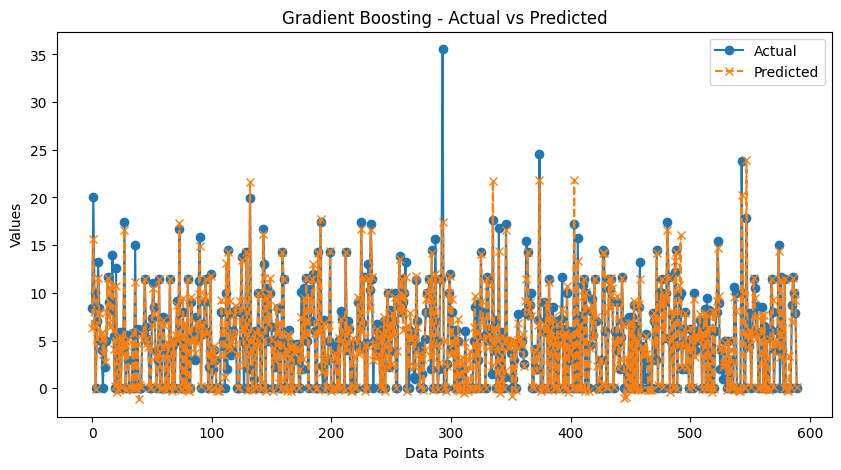

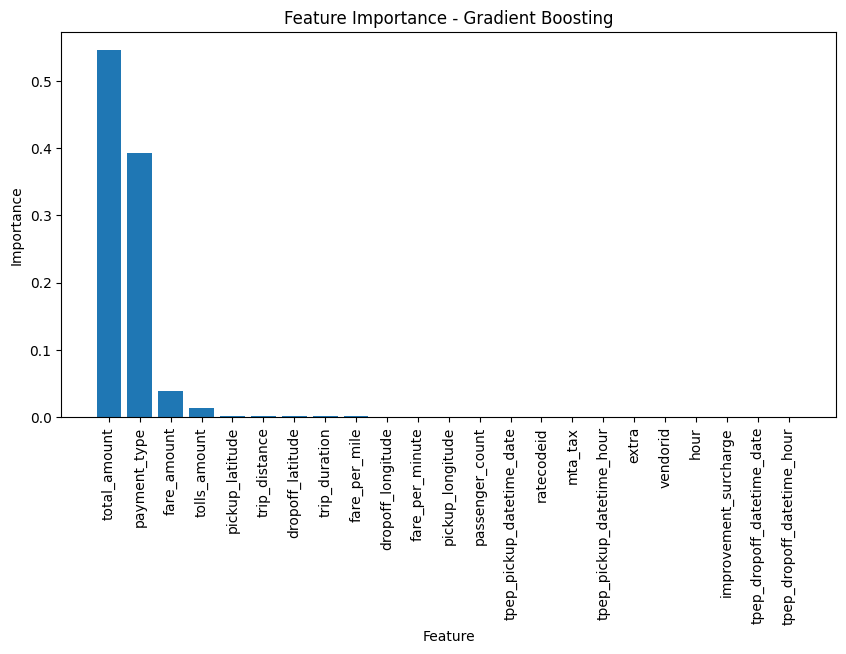

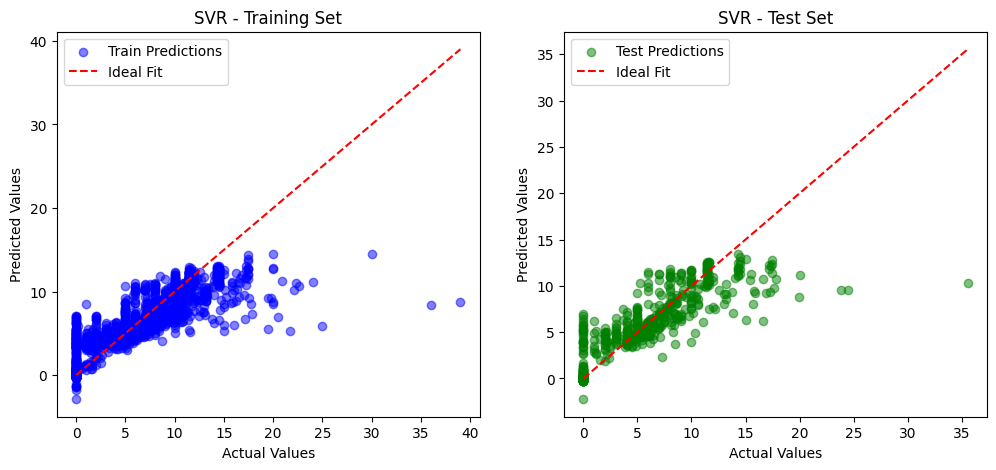

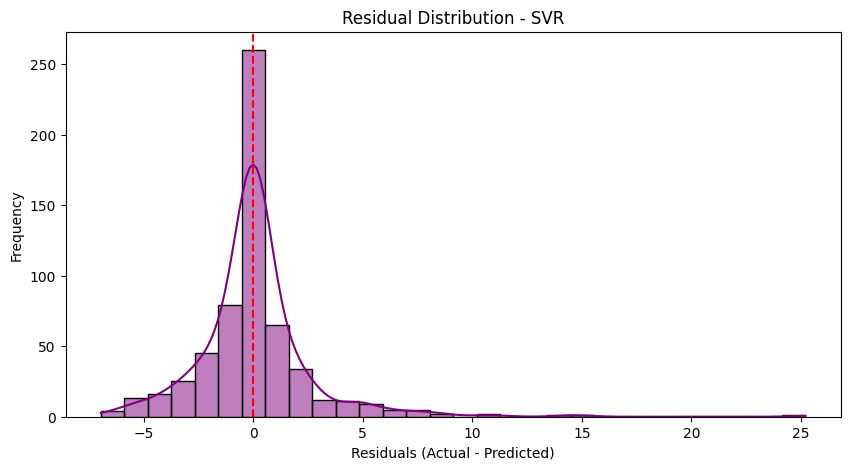

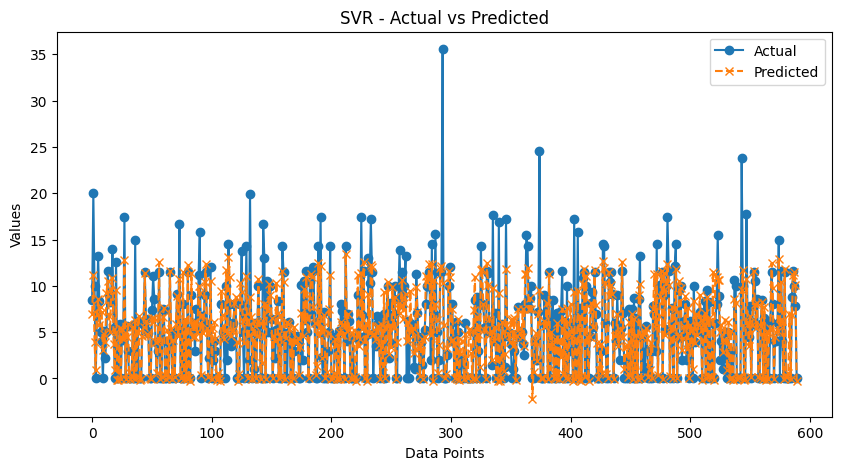

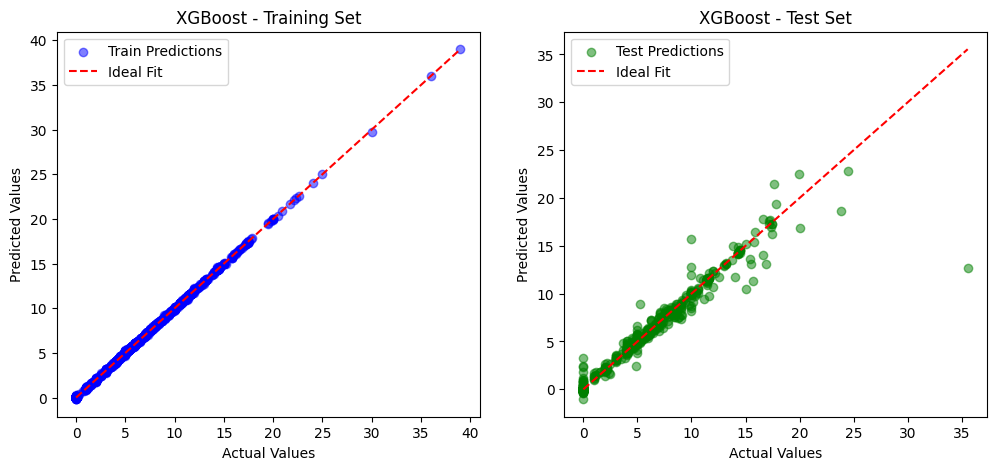

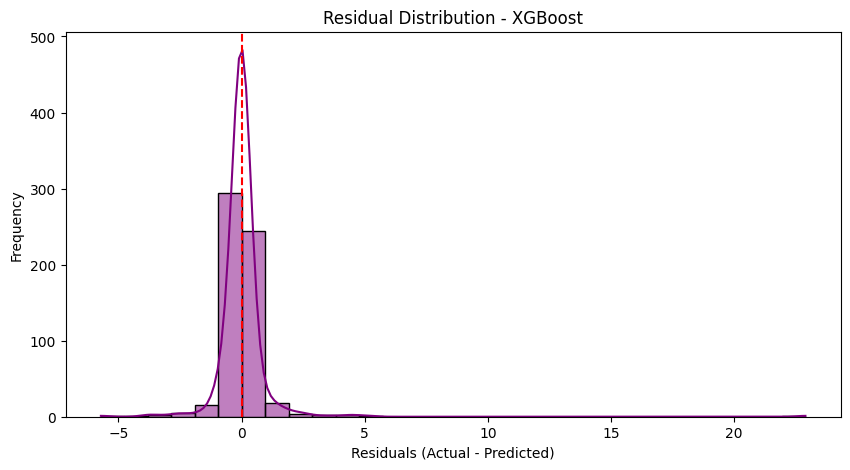

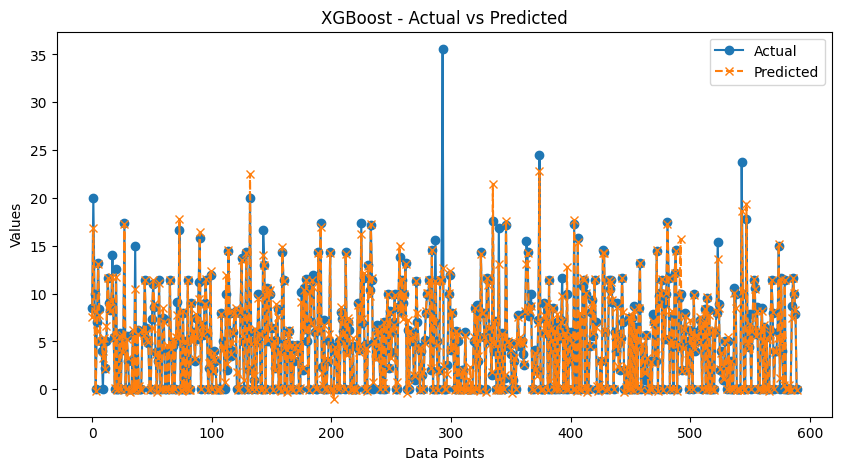

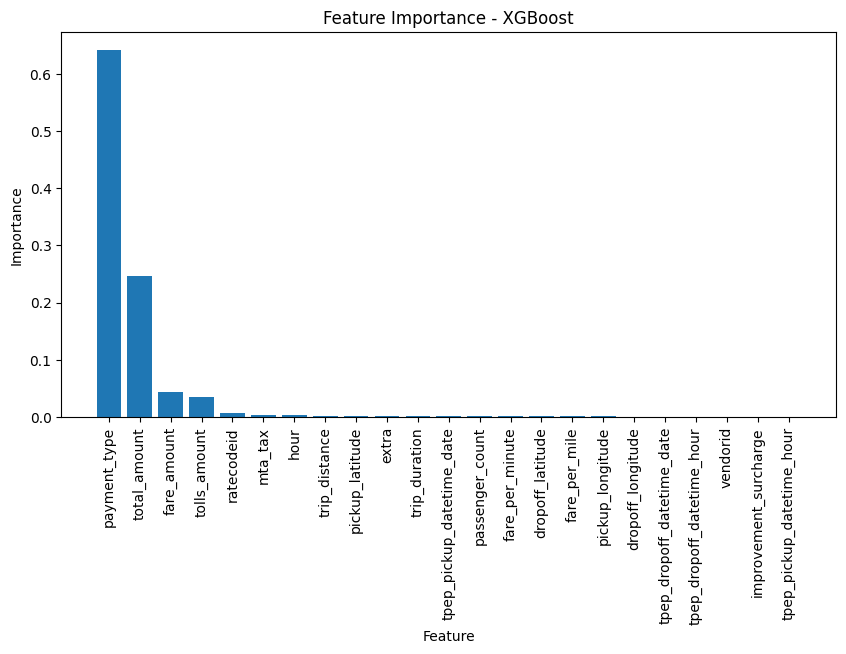

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


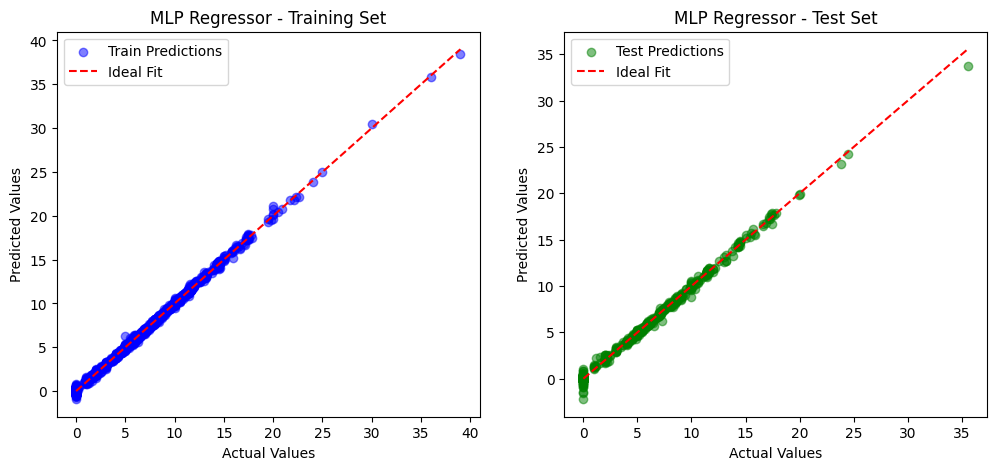

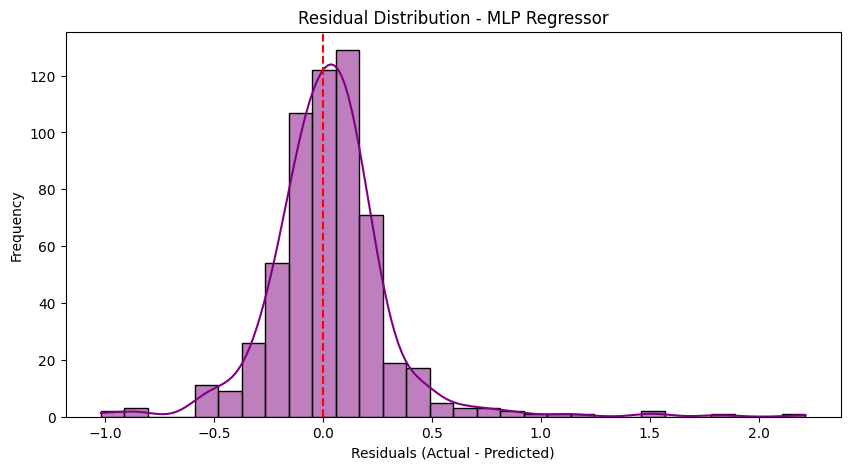

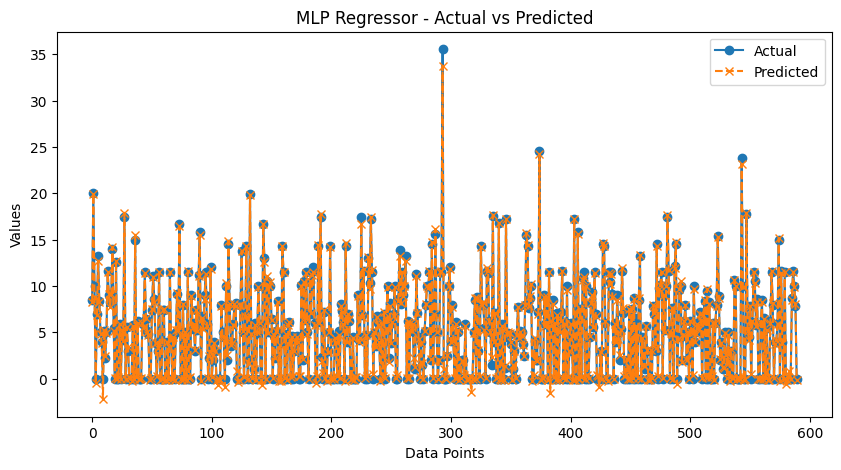

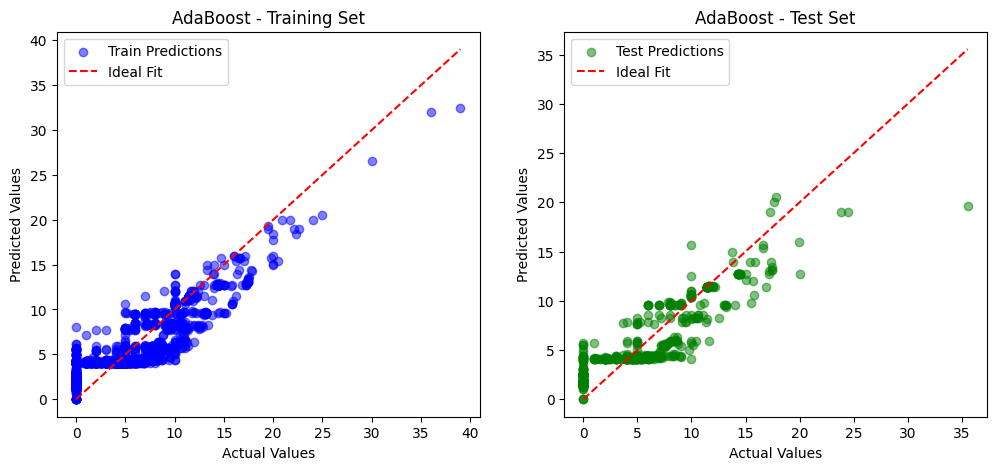

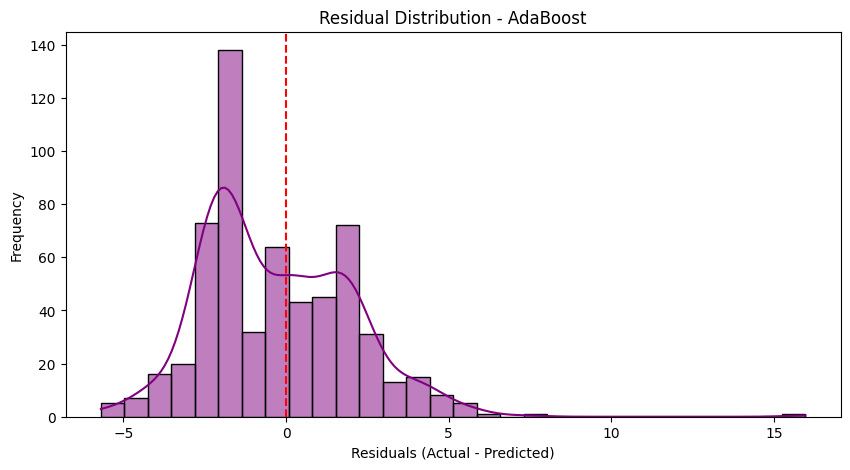

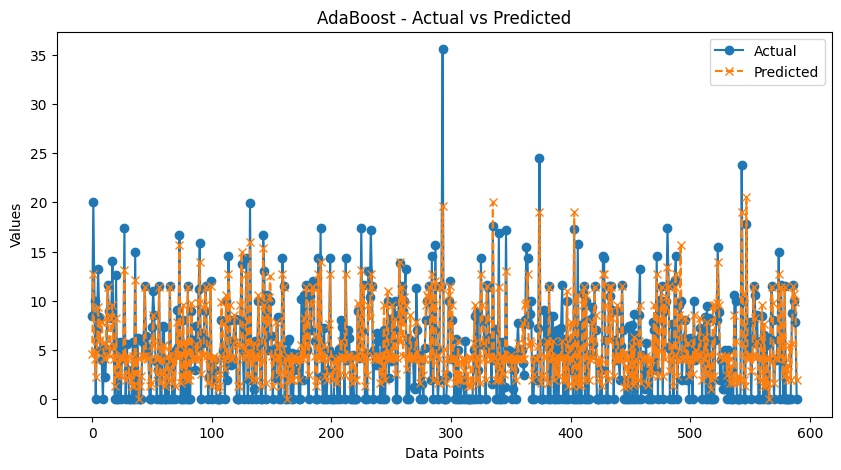

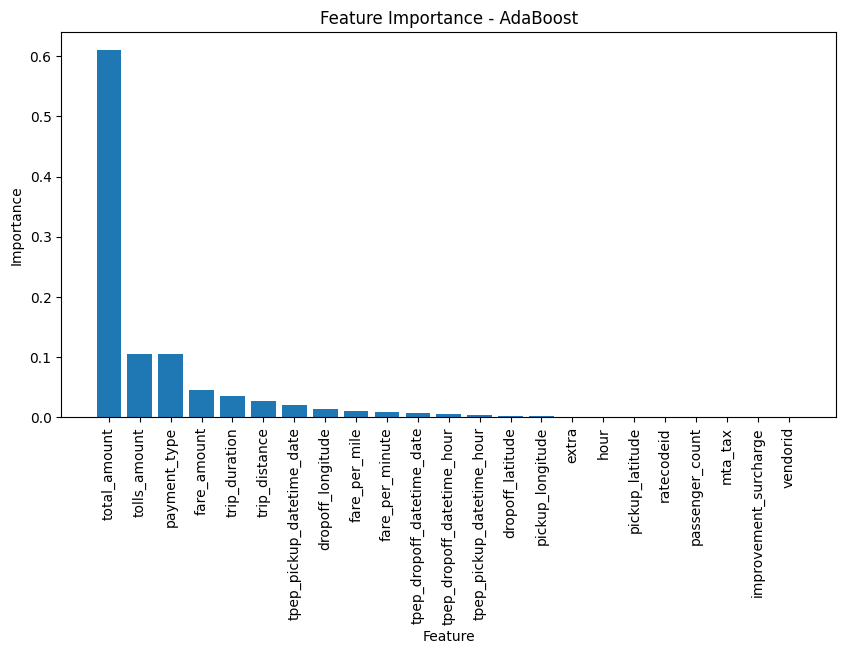

In [48]:
# Define models with and without hyperparameter tuning
models_no_tuning = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(),
    "MLP Regressor": MLPRegressor(),
    "AdaBoost": AdaBoostRegressor()
}

# Train and evaluate models without tuning
results_no_tuning = {}
for model_name, model in models_no_tuning.items():
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    results_no_tuning[model_name] = {
        "MAE": mean_absolute_error(y_test, test_pred),
        "MSE": mean_squared_error(y_test, test_pred),
        "R2 Score": r2_score(y_test, test_pred),
        "MAPE": mean_absolute_percentage_error(y_test, test_pred),
        "Explained Variance": explained_variance_score(y_test, test_pred)
    }

    plot_train_vs_test(y_train, train_pred, y_test, test_pred, model_name)
    plot_residuals(y_test, test_pred, model_name)
    plot_loss(y_test, test_pred, model_name)
    plot_feature_importance(model, X, model_name)

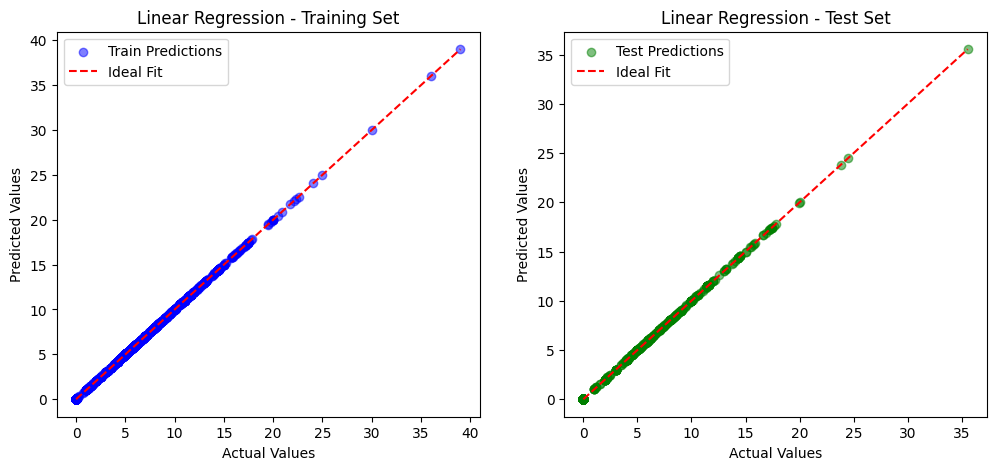

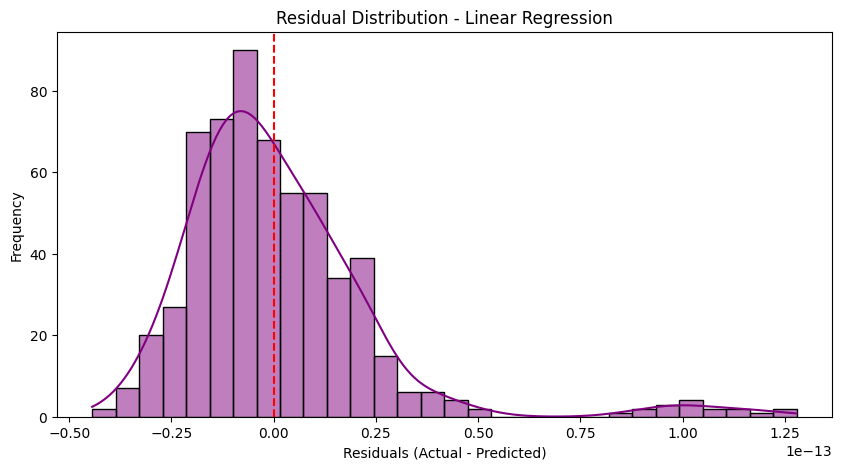

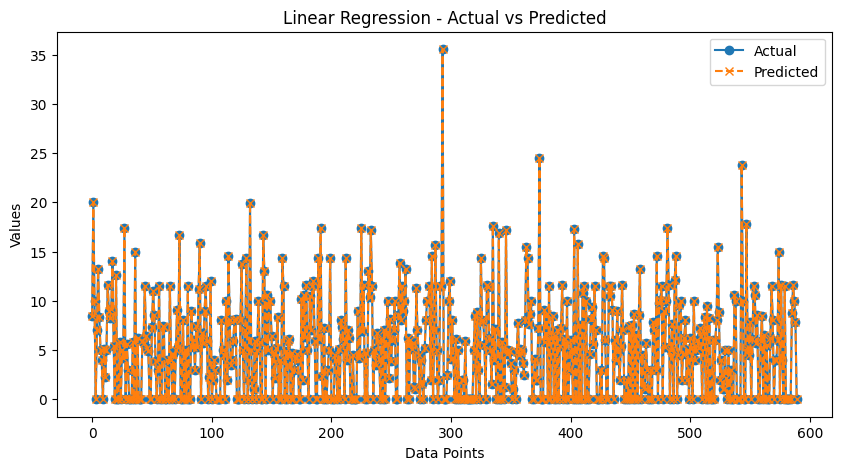

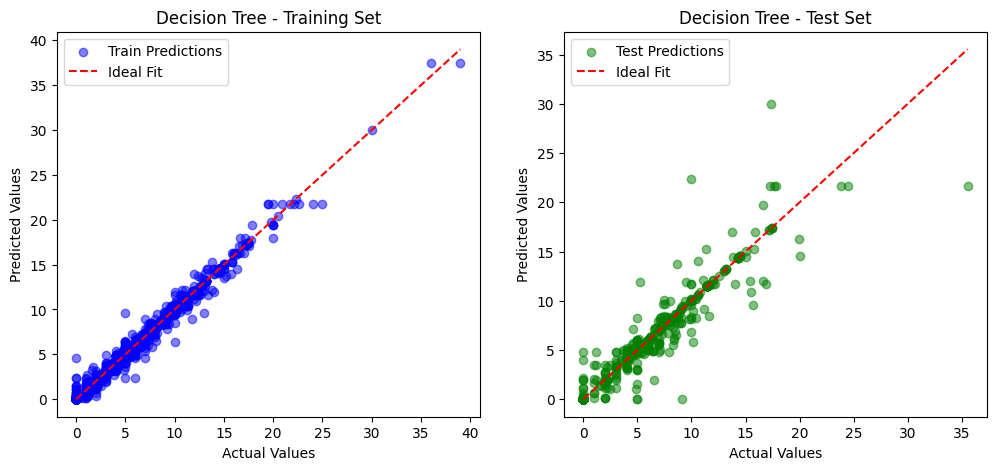

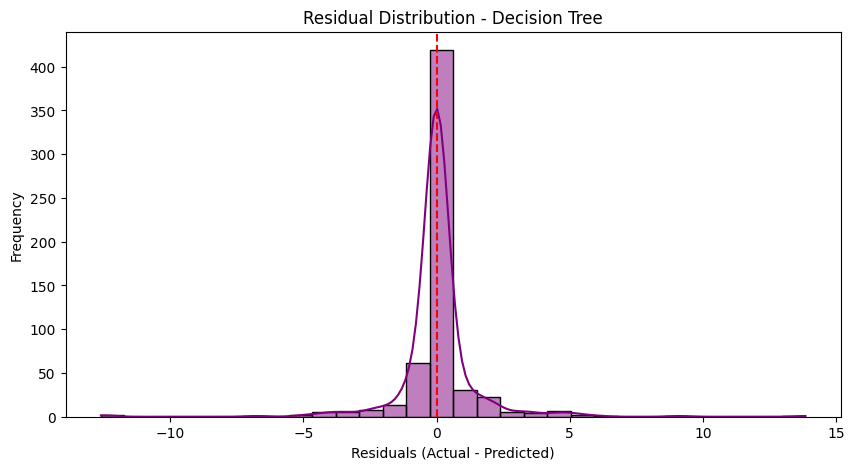

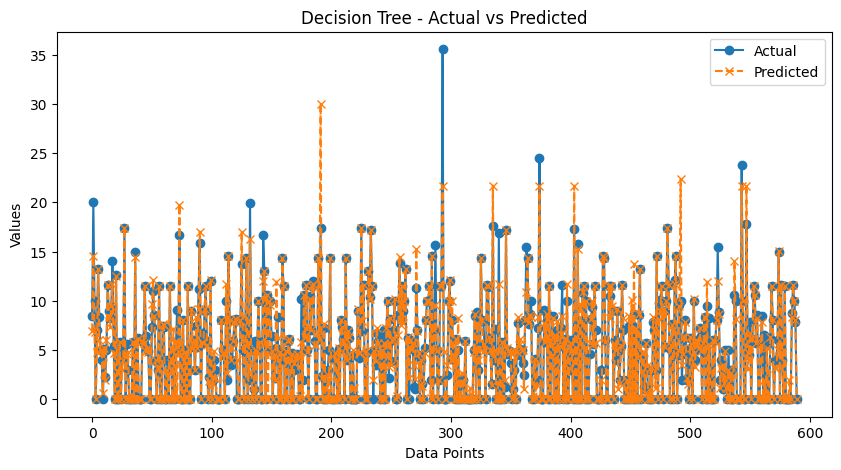

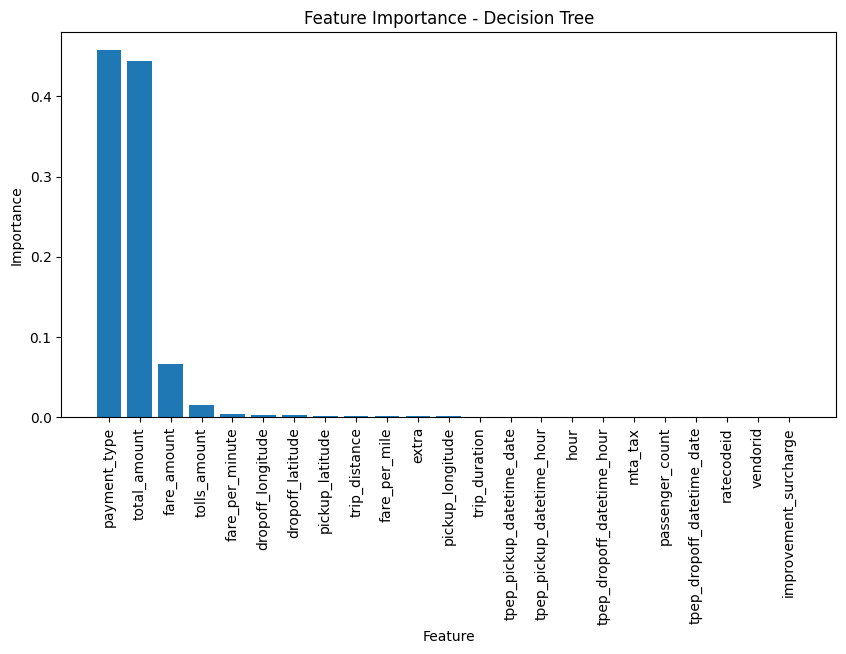

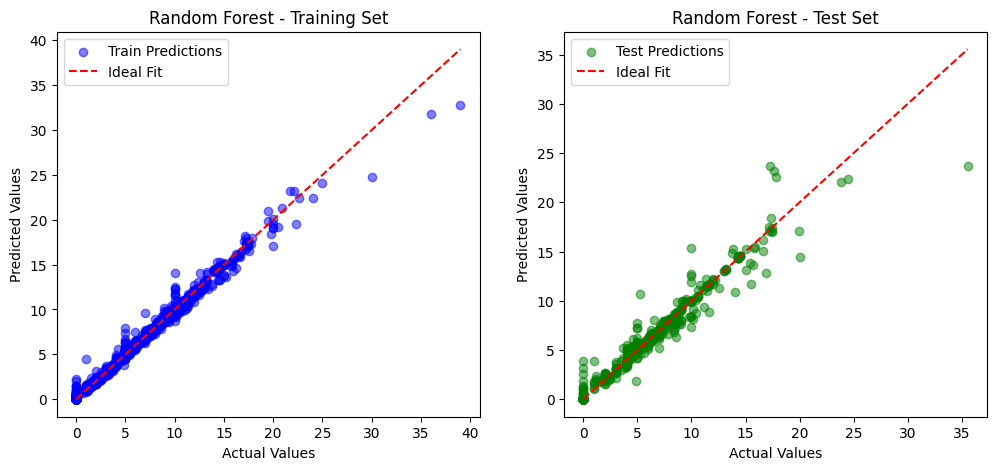

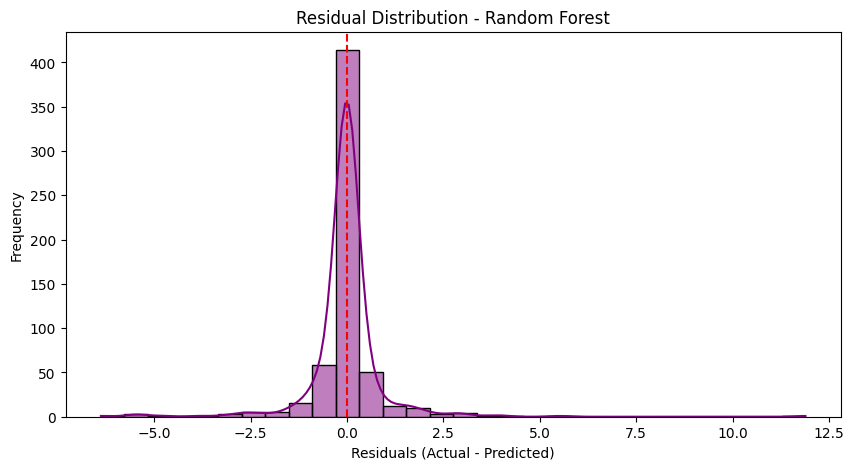

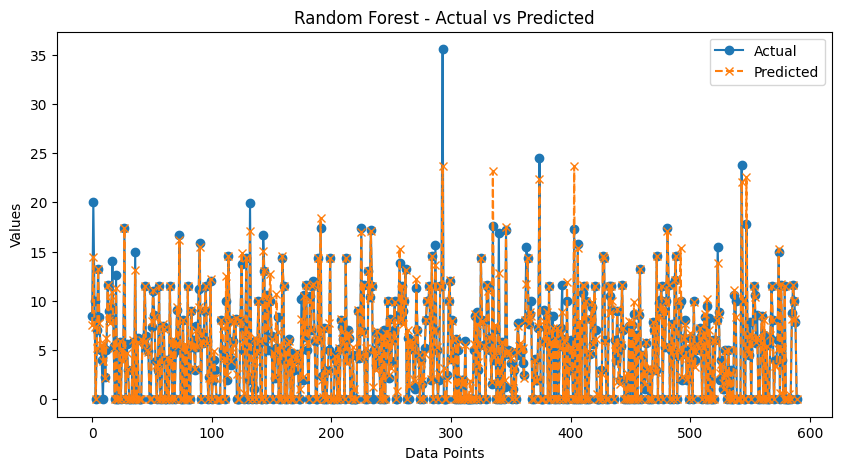

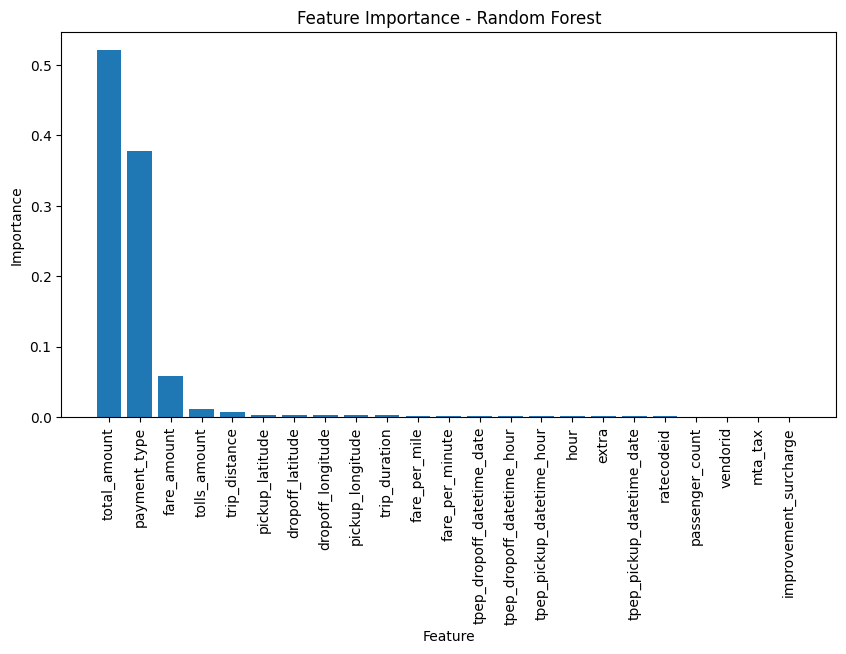

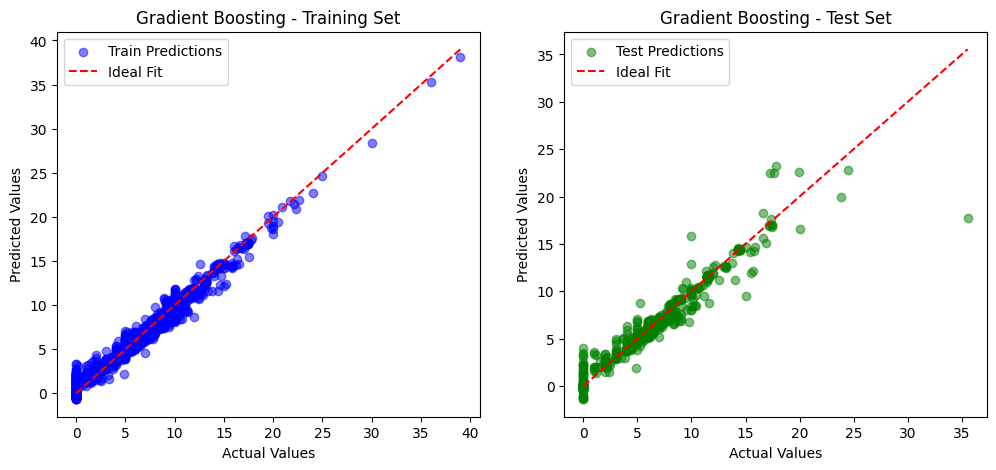

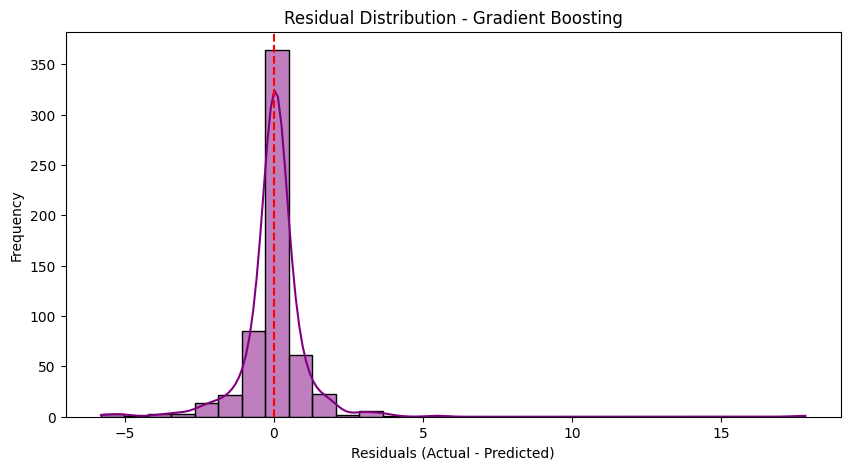

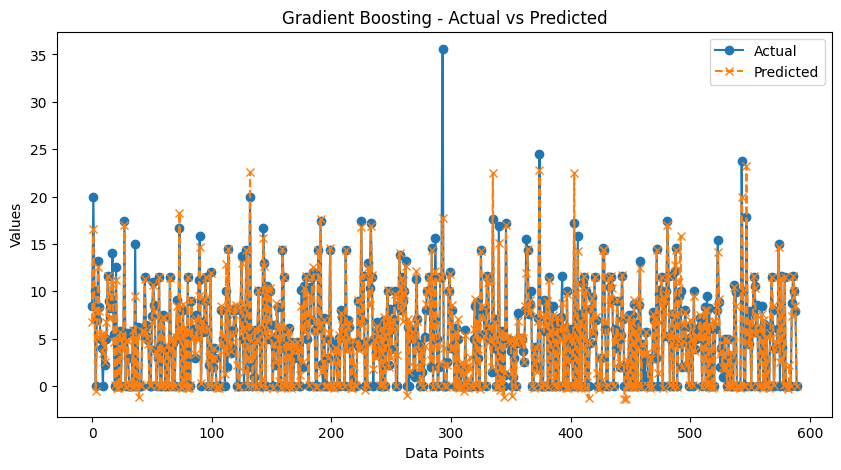

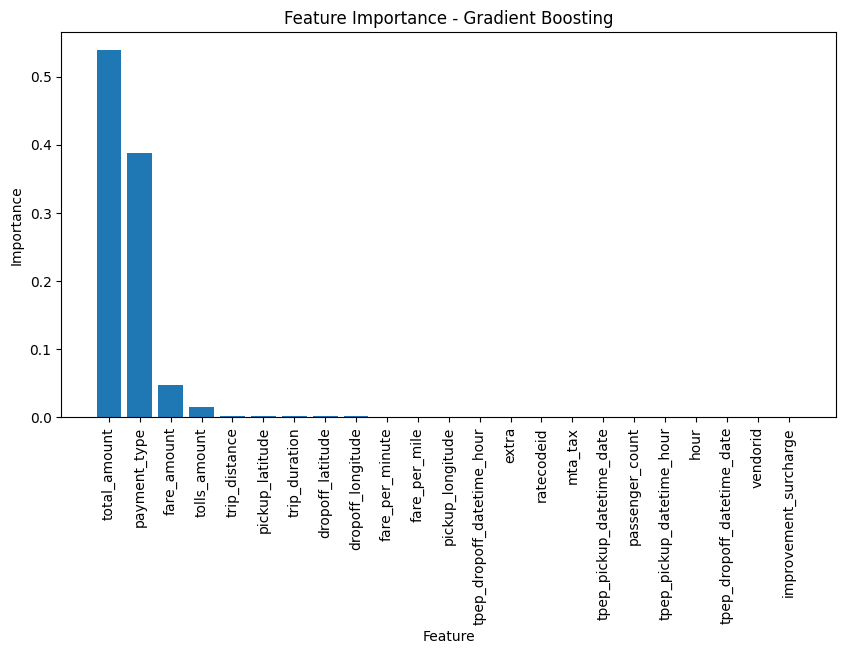

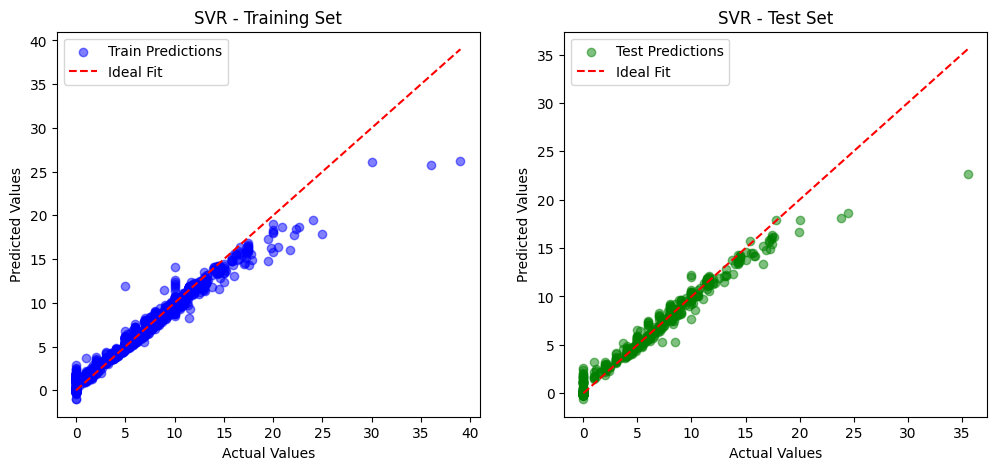

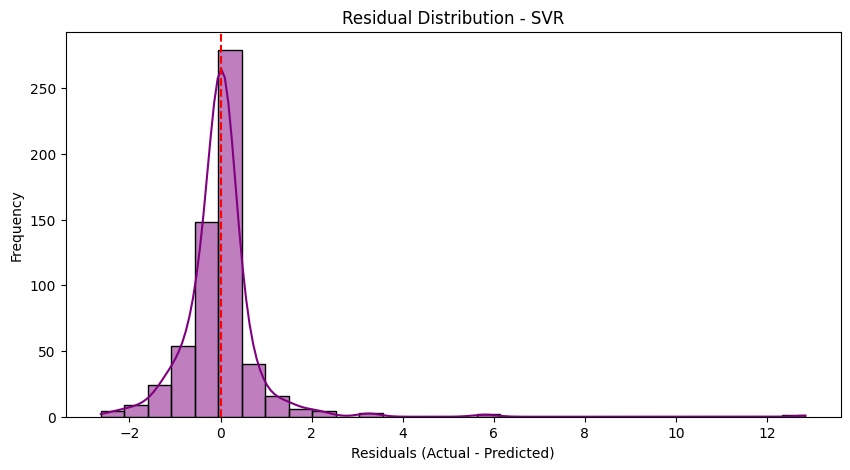

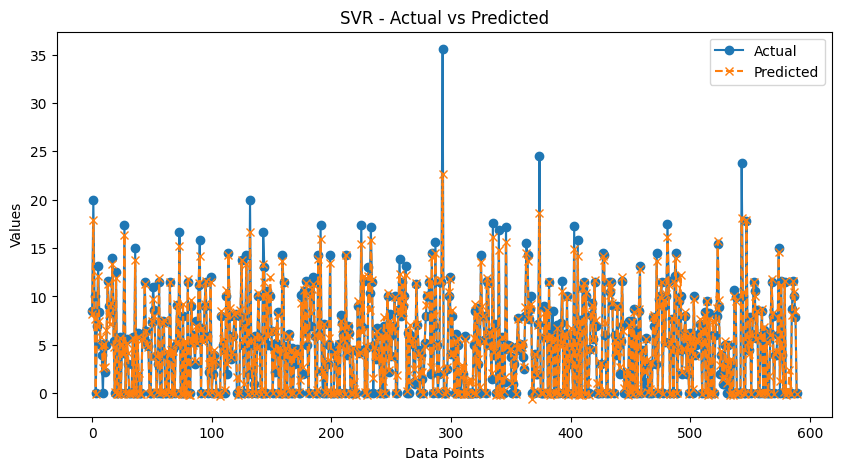

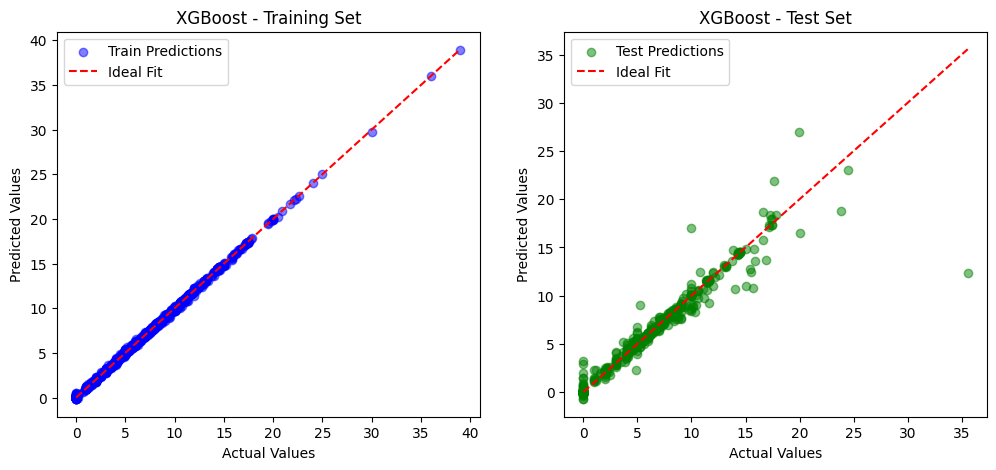

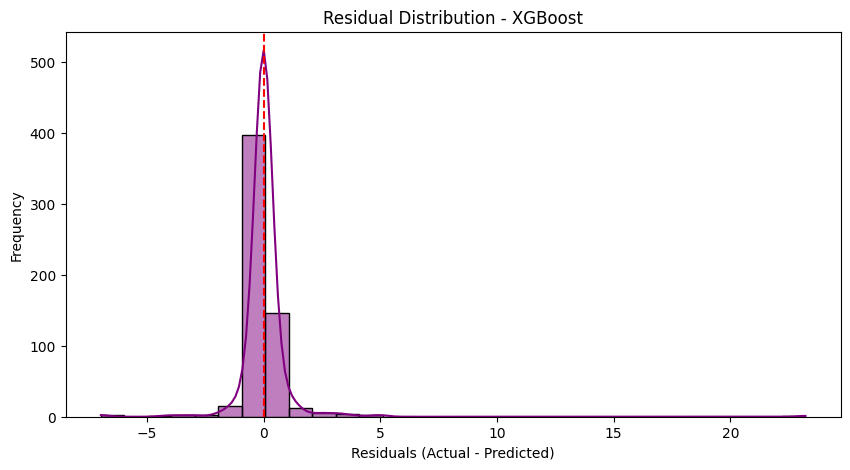

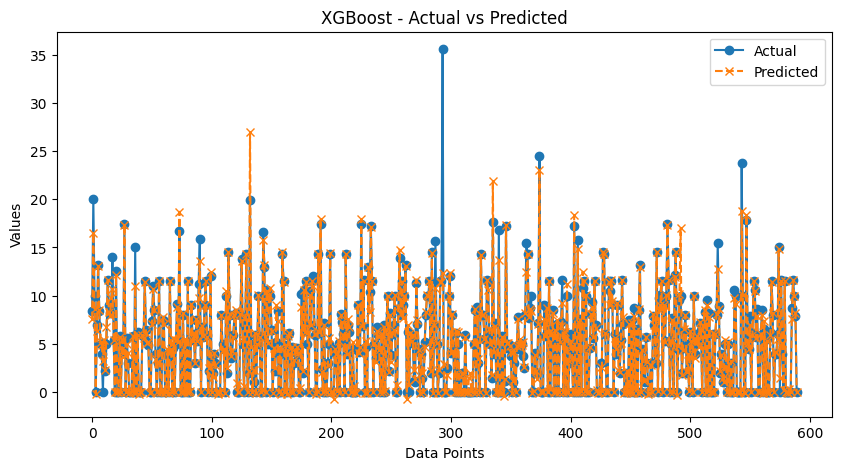

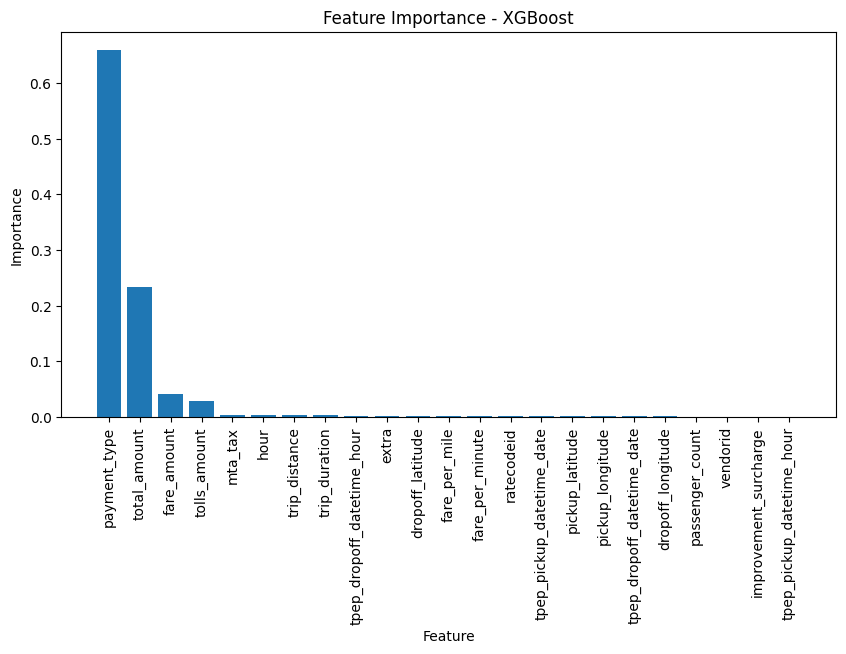

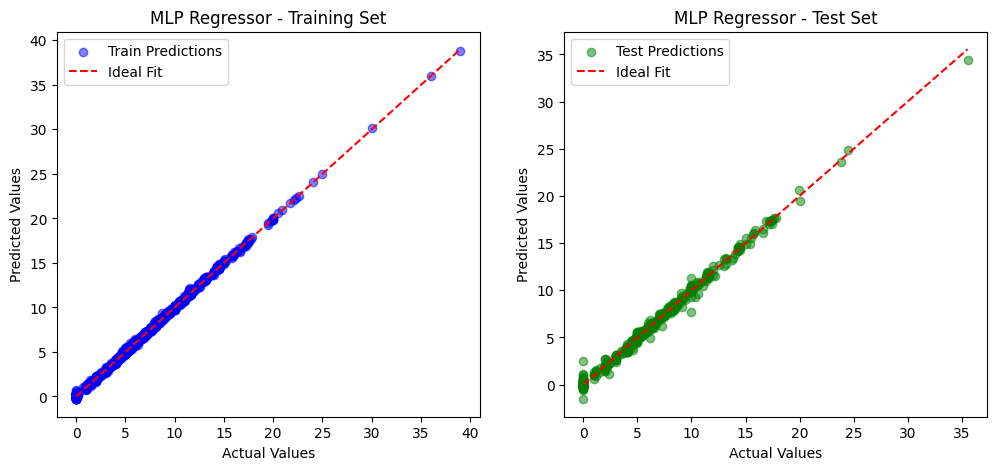

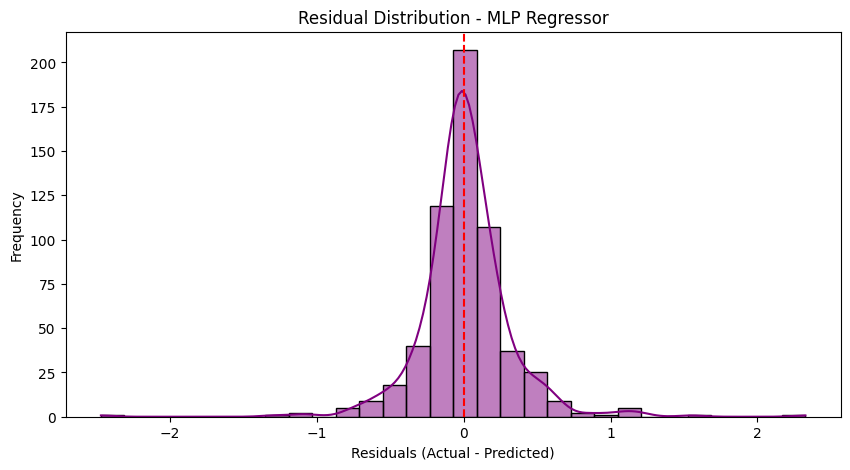

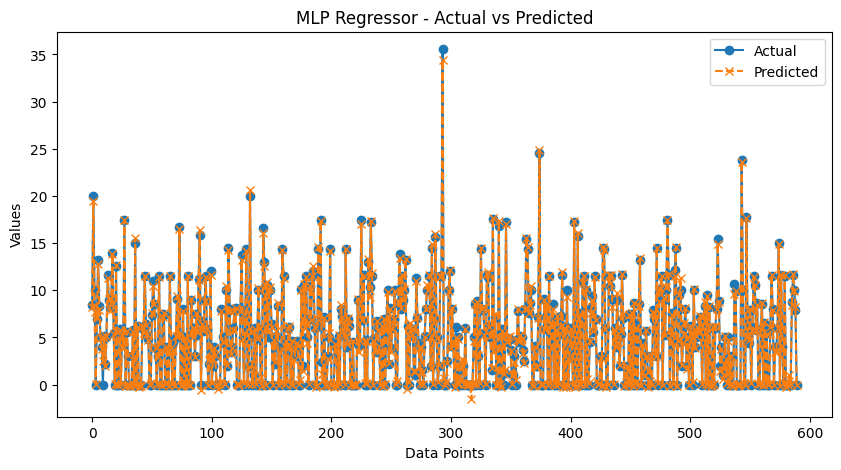

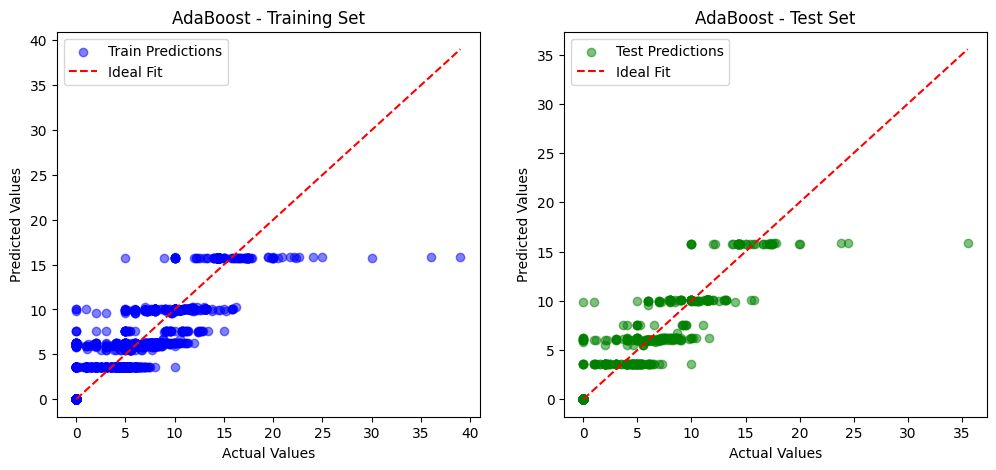

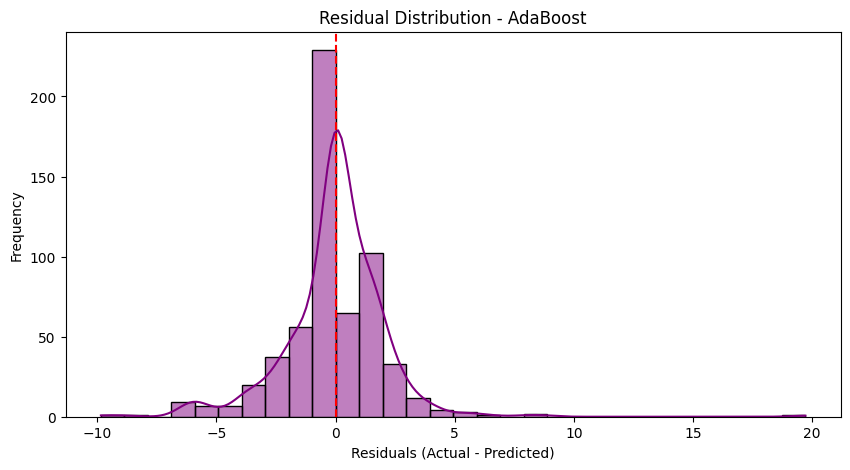

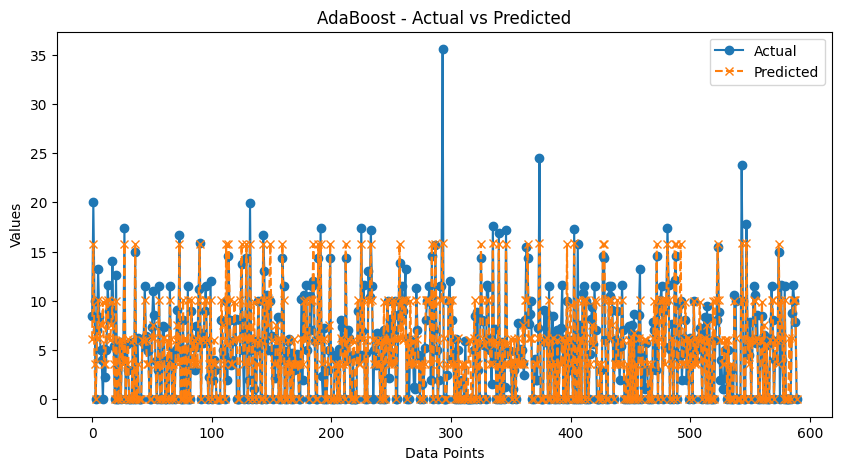

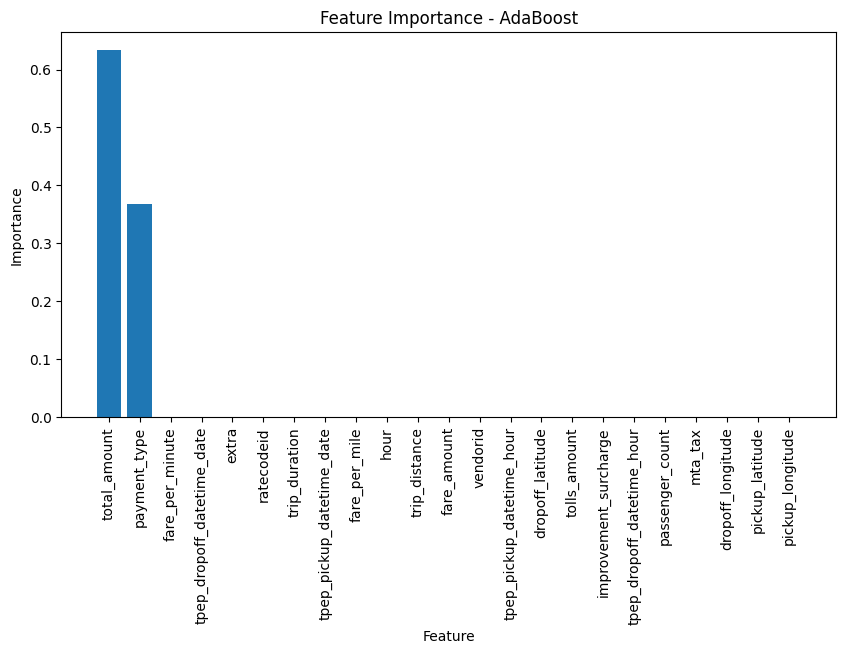

In [49]:
# Define hyperparameter grids
param_grid = {
    "Decision Tree": {"max_depth": [5, 10, 20], "min_samples_split": [2, 5, 10]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [10, 20]},
    "Gradient Boosting": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.05, 0.1]},
    "SVR": {"C": [0.1, 1, 10], "gamma": [0.01, 0.1, 1]},
    "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.05, 0.1]},
    "MLP Regressor": {"hidden_layer_sizes": [(50, 50), (100, 50), (100, 100)], "max_iter": [500, 1000]},
    "AdaBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.05, 0.1]}
}

# Define models for hyperparameter tuning
models_tuning = {
    "Linear Regression": LinearRegression(),  # No tuning needed
    "Decision Tree": GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid["Decision Tree"], cv=3),
    "Random Forest": GridSearchCV(RandomForestRegressor(), param_grid=param_grid["Random Forest"], cv=3),
    "Gradient Boosting": GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid["Gradient Boosting"], cv=3),
    "SVR": GridSearchCV(SVR(), param_grid=param_grid["SVR"], cv=3),
    "XGBoost": GridSearchCV(XGBRegressor(), param_grid=param_grid["XGBoost"], cv=3),
    "MLP Regressor": GridSearchCV(MLPRegressor(), param_grid=param_grid["MLP Regressor"], cv=3),
    "AdaBoost": GridSearchCV(AdaBoostRegressor(), param_grid=param_grid["AdaBoost"], cv=3)
}

# Train and evaluate models with tuning
results_tuning = {}
for model_name, model in models_tuning.items():
    model.fit(X_train, y_train)
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    y_pred = best_model.predict(X_test)

    results_tuning[model_name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred),
        "Explained Variance": explained_variance_score(y_test, y_pred)
    }

    plot_train_vs_test(y_train, best_model.predict(X_train), y_test, y_pred, model_name)
    plot_residuals(y_test, y_pred, model_name)
    plot_loss(y_test, y_pred, model_name)
    plot_feature_importance(best_model, X, model_name)

In [50]:
results_no_tuning_df= pd.DataFrame(results_no_tuning).T
print(results_no_tuning_df)

                            MAE           MSE  R2 Score          MAPE  \
Linear Regression  1.626834e-14  5.902307e-28  1.000000  2.347797e+01   
Decision Tree      6.014746e-01  2.452101e+00  0.903520  1.083917e+14   
Random Forest      4.007436e-01  1.023239e+00  0.959740  1.519713e+14   
Gradient Boosting  7.794946e-01  1.991835e+00  0.921629  6.169937e+14   
SVR                1.515662e+00  6.941539e+00  0.726878  1.209141e+15   
XGBoost            3.946737e-01  1.433972e+00  0.943579  2.509276e+14   
MLP Regressor      1.840019e-01  8.002226e-02  0.996851  2.850135e+14   
AdaBoost           1.914966e+00  5.466215e+00  0.784926  3.287139e+15   

                   Explained Variance  
Linear Regression            1.000000  
Decision Tree                0.903588  
Random Forest                0.959744  
Gradient Boosting            0.921632  
SVR                          0.727060  
XGBoost                      0.943623  
MLP Regressor                0.996885  
AdaBoost              

In [51]:
results_df_tuning = pd.DataFrame(results_tuning).T
print(results_df_tuning)

                            MAE           MSE  R2 Score          MAPE  \
Linear Regression  1.626834e-14  5.902307e-28  1.000000  2.347797e+01   
Decision Tree      6.040779e-01  2.341064e+00  0.907888  1.409783e+14   
Random Forest      4.050119e-01  1.026725e+00  0.959602  1.534590e+14   
Gradient Boosting  5.856499e-01  1.509671e+00  0.940600  5.112728e+14   
SVR                4.607975e-01  8.363739e-01  0.967092  4.121211e+14   
XGBoost            3.818771e-01  1.561394e+00  0.938565  1.966719e+14   
MLP Regressor      1.992212e-01  1.002909e-01  0.996054  2.226489e+14   
AdaBoost           1.306403e+00  4.594509e+00  0.819224  6.733110e+14   

                   Explained Variance  
Linear Regression            1.000000  
Decision Tree                0.907970  
Random Forest                0.959612  
Gradient Boosting            0.940615  
SVR                          0.967093  
XGBoost                      0.938636  
MLP Regressor                0.996059  
AdaBoost              

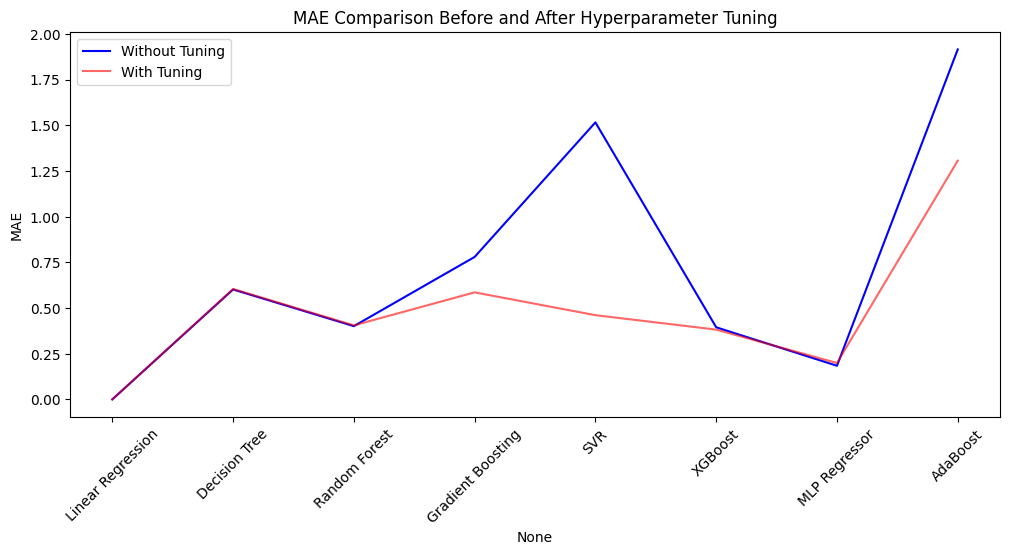

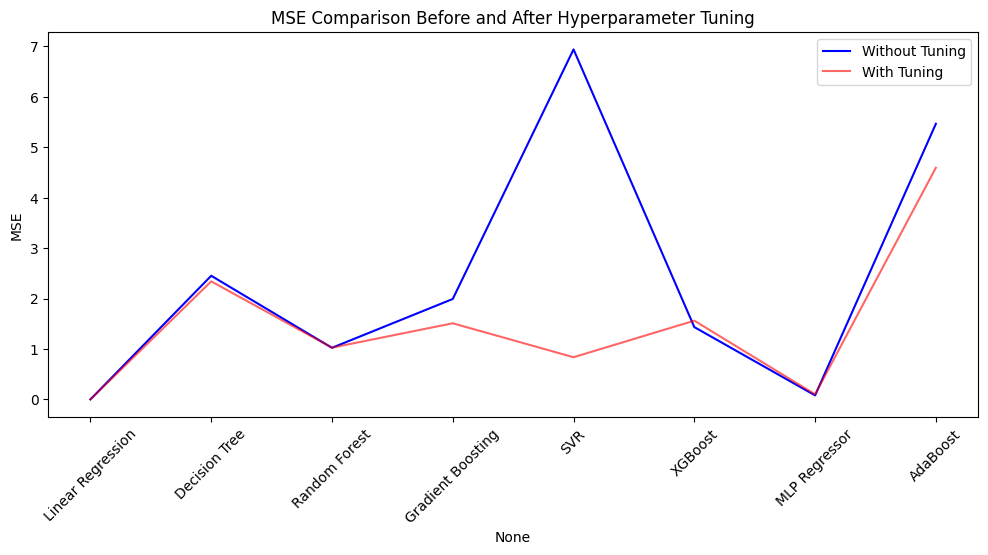

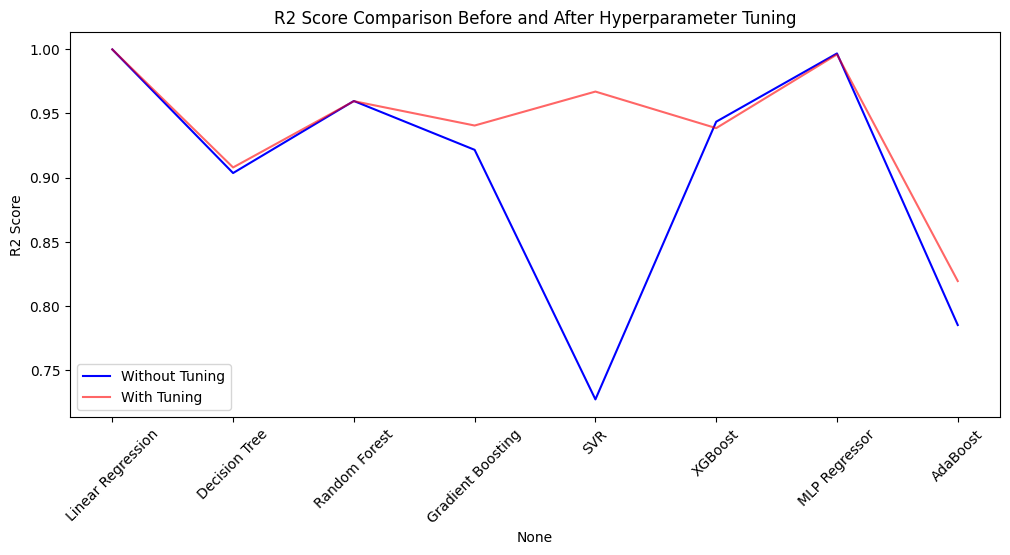

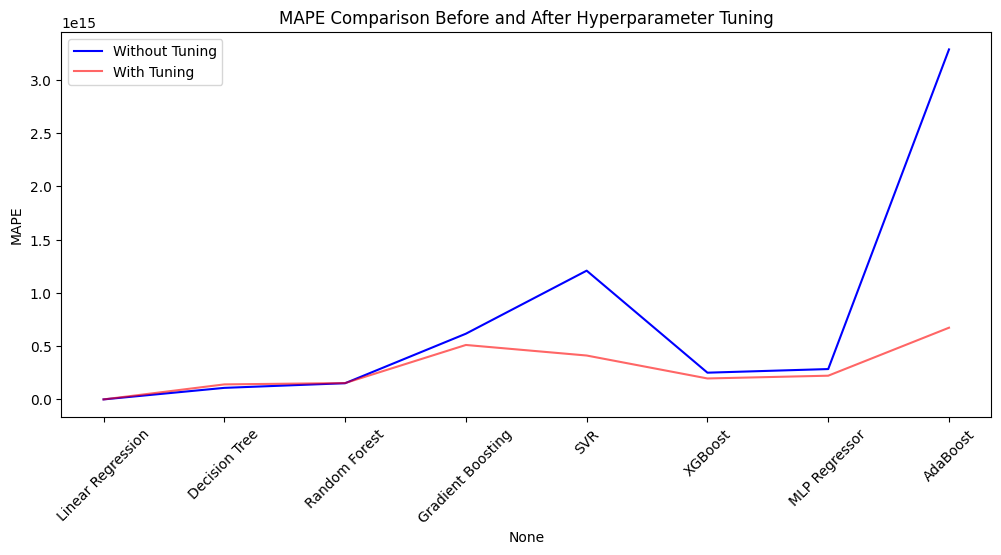

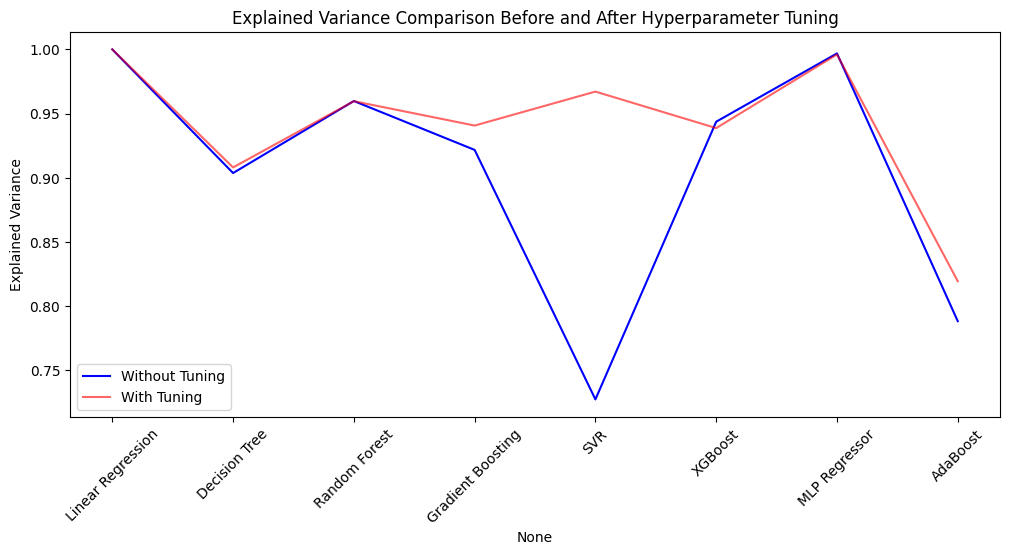

In [52]:
# Define error metrics to compare
metrics = ["MAE", "MSE", "R2 Score","MAPE","Explained Variance"]

# Plot comparison of errors before and after tuning
for metric in metrics:
    plt.figure(figsize=(12, 5))

    sns.lineplot(x=results_no_tuning_df.index, y=results_no_tuning_df[metric], color="blue", label="Without Tuning")
    sns.lineplot(x=results_df_tuning.index, y=results_df_tuning[metric], color="red", alpha=0.6, label="With Tuning")

    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.title(f"{metric} Comparison Before and After Hyperparameter Tuning")
    plt.legend()
    plt.show()

In [53]:
df['payment_type']

27       1
37       1
58       2
78       2
83       1
        ..
99845    2
99948    3
99963    2
99996    1
99998    2
Name: payment_type, Length: 2947, dtype: int64

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle

# Load your dataset
# df = pd.read_csv("your_cleaned_data.csv")  ← if needed

# Encode payment_type
df["payment_type"] = df["payment_type"].map({
    "Credit Card": 1,
    "Cash": 2,
    "No Charge": 3,
    "Dispute": 4,
    "Unknown": 5
})

# FILTER: Remove rows with very low or zero tips
df = df[df["tip_amount"] >= 1.0]

# Select features
features = [
    "trip_distance", "passenger_count", "fare_amount", "extra", "mta_tax",
    "tolls_amount", "improvement_surcharge", "total_amount", "payment_type", "trip_duration"
]

X = df[features]
y = df["tip_amount"]

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train models
dt_model = DecisionTreeRegressor(max_depth=5)
dt_model.fit(X_train_scaled, y_train)

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

# Save
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("dt_model.pkl", "wb") as f:
    pickle.dump(dt_model, f)

with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)





C:\Users\DELL\AppData\Local\Temp\ipykernel_13088\297530916.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["payment_type"] = df["payment_type"].map({
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correcti

In [60]:
# Load scaler
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Scale user input
X_scaled = scaler.transform(X)